# ALZHEIMER'S DISEASE - DEEP LEARNING

In [1]:
import xnat

import os
import nibabel as nib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob

import cv2

from skimage import transform

import tensorflow as tf 
from sklearn.model_selection import GridSearchCV
import keras
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import nltk
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.feature_extraction.text import TfidfVectorizer

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import layers
from keras import models
from keras.models import load_model


from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score


from distutils.dir_util import copy_tree

import shutil
import random

# 1. DATA ACQUISITION

### 1.1 Connecting to the XNAT API session of the OASIS-3 project

Permission has to be requested to the Open Access Series of Imaging Studies (OASIS) dataset to be able to set a username and password and obtain access to the data due to the high volume of information.

In [19]:
session = xnat.connect('https://central.xnat.org', user= 'lauradima', password = 'PaulaLauraIDbootcamps2023') # API

sandbox = session.projects["OASIS3"] # OASIS3 project

# Loading elements of interest from the dataset (sujects), using (dir) to understand its directories 
sujetos = sandbox.subjects   # List of subjets with format: (CENTRAL_S05143, OAS30061): <SubjectData OAS30061 (CENTRAL_S05143)>

### 1.2 Loading Tw1 MRI from each subject and downloading it to a local directory

In [36]:
# Defining base directory
base_folder = "T1wsujetos"

for subject in sujetos[0:1379]:
    for key, folder in subject.experiments.items():
        if "mr" in folder.xpath.lower():
            print(f"Found MrSession: {key}")
            
            # Iterate through scans
            for scan_key, scan_value in folder.scans.items():
                
                # Check if the scan type is 'T1w'
                if "T1w" in scan_value.type:
                    
                    print(f"Found T1w scan: {scan_key}")
                    
                    # Iterate through resources
                    for resource_key, resource_value in scan_value.resources.items():
                        
                        # Check if the resource label is 'NIFTI' (type of file)
                        if resource_value.label.lower() == 'nifti':
                            print(f"Downloading NIFTI files for T1w scan: {scan_key}")
                            
                            try:
                                # Creating path for the resulting file
                                output_folder = os.path.join(base_folder, f"{folder.label}_{round(folder.age)}_T1w_NIFTI")
                                # Age is included in the name because we will need it for future verifications

                                # Checking if folder already exists before creating
                                if not os.path.exists(output_folder):
                                    os.makedirs(output_folder)

                                resource_value.download_dir(output_folder) #Estaba fuera del if not
                            
                            # We use this except as a way to check to possible mistakes in the selection 
                            except:
                                print('ERROR')

Found MrSession: CENTRAL02_E02424
Found T1w scan: anat2


  8.0 MiB |         #                                             |   6.1 MiB/s


Found MrSession: CENTRAL_E10790
Found T1w scan: anat2


 10.8 MiB |  #                                                    |  15.7 MiB/s


Found T1w scan: anat3


 10.8 MiB |       #                                               |  11.9 MiB/s


Found MrSession: CENTRAL_E10791
Found T1w scan: anat2


 11.0 MiB |   #                                                   |   1.1 MiB/s


Found T1w scan: anat3


 11.1 MiB |    #                                                  |  26.4 MiB/s


Found MrSession: CENTRAL_E10792
Found T1w scan: anat2


 10.8 MiB |    #                                                  |  22.3 MiB/s


Found T1w scan: anat3


 10.8 MiB |     #                                                 |  18.9 MiB/s


Found MrSession: CENTRAL_E10793
Found T1w scan: anat3


 10.7 MiB |    #                                                  |  21.1 MiB/s


Found MrSession: CENTRAL_E10794
Found T1w scan: anat4


  9.6 MiB |    #                                                  |  19.6 MiB/s


Found MrSession: CENTRAL_E10813
Found T1w scan: anat2


 10.7 MiB |    #                                                  |  19.8 MiB/s


Found T1w scan: anat3


 10.8 MiB |    #                                                  |  20.2 MiB/s


Found MrSession: CENTRAL_E10795
Found T1w scan: anat2


 10.1 MiB | #                                                     |  51.4 MiB/s


Found T1w scan: anat3


 10.0 MiB |  #                                                    |  49.5 MiB/s


Found MrSession: CENTRAL_E10796
Found T1w scan: anat2


  9.8 MiB |   #                                                   |   1.8 MiB/s


Found T1w scan: anat3


  9.9 MiB | #                                                     |  54.0 MiB/s


Found MrSession: CENTRAL_E10797
Found T1w scan: anat2


 10.0 MiB |   #                                                   |   7.8 MiB/s


Found T1w scan: anat3


 10.0 MiB |   #                                                   |   9.5 MiB/s


Found MrSession: CENTRAL_E11397
Found T1w scan: anat3


 12.4 MiB |   #                                                   |  10.6 MiB/s


Found MrSession: CENTRAL_E10816
Found T1w scan: anat2


 10.3 MiB |    #                                                  |   3.7 MiB/s


Found T1w scan: anat3


 10.3 MiB |   #                                                   |   6.7 MiB/s


Found MrSession: CENTRAL_E10817
Found T1w scan: anat2


 10.2 MiB |   #                                                   |   6.7 MiB/s


Found MrSession: CENTRAL_E10818
Found T1w scan: anat4


  9.2 MiB |   #                                                   |   8.0 MiB/s


Found MrSession: CENTRAL_E10801
Found T1w scan: anat2


 10.6 MiB | #                                                     |  56.5 MiB/s


Found T1w scan: anat3


 10.5 MiB | #                                                     |  57.4 MiB/s


Found MrSession: CENTRAL_E10814
Found T1w scan: anat2


 10.9 MiB |   #                                                   |   6.1 MiB/s


Found MrSession: CENTRAL_E10815
Found T1w scan: anat4


  9.6 MiB |    #                                                  |   8.9 MiB/s


Found MrSession: CENTRAL02_E02501
Found T1w scan: anat4


 10.4 MiB | #                                                     |  50.3 MiB/s


Found MrSession: CENTRAL_E10877
Found T1w scan: anat2


 10.8 MiB |    #                                                  |  23.1 MiB/s


Found MrSession: CENTRAL_E10878
Found T1w scan: anat4


 10.4 MiB |    #                                                  |  21.4 MiB/s


Found MrSession: CENTRAL_E10879
Found T1w scan: anat4


 10.2 MiB |   #                                                   |  19.8 MiB/s


Found MrSession: CENTRAL_E72201
Found T1w scan: anat2


 11.5 MiB |    #                                                  |  21.0 MiB/s


Found MrSession: CENTRAL_E10848
Found T1w scan: anat3


 11.4 MiB |    #                                                  |  13.5 MiB/s


Found MrSession: CENTRAL_E10804
Found T1w scan: anat2


  9.1 MiB |   #                                                   |   8.7 MiB/s


Found MrSession: CENTRAL_E10834
Found T1w scan: anat2


  9.4 MiB |   #                                                   |   9.7 MiB/s


Found MrSession: CENTRAL02_E02914
Found T1w scan: anat2


 10.9 MiB |   #                                                   |  10.2 MiB/s


Found MrSession: CENTRAL02_E03012
Found T1w scan: anat2


 11.1 MiB |   #                                                   |   9.3 MiB/s


Found T1w scan: anat5


 11.1 MiB |    #                                                  |  24.1 MiB/s


Found MrSession: CENTRAL02_E06143
Found T1w scan: anat1


 10.8 MiB |    #                                                  |  22.5 MiB/s


Found MrSession: CENTRAL_E10872
Found T1w scan: anat5


 10.7 MiB |    #                                                  |  19.2 MiB/s


Found MrSession: CENTRAL_E10873
Found T1w scan: anat4


 10.3 MiB |    #                                                  |  17.9 MiB/s


Found MrSession: CENTRAL_E10874
Found T1w scan: anat4


 10.5 MiB |   #                                                   |  20.7 MiB/s


Found MrSession: CENTRAL_E72203
Found T1w scan: anat6


 11.0 MiB |    #                                                  |  19.0 MiB/s


Found MrSession: CENTRAL_E10832
Found T1w scan: anat2


 11.1 MiB |    #                                                  |  17.6 MiB/s


Found MrSession: CENTRAL_E10833
Found T1w scan: anat2


 10.7 MiB |    #                                                  |  16.6 MiB/s


Found MrSession: CENTRAL_E10905
Found T1w scan: anat2


 11.1 MiB |    #                                                  |  16.3 MiB/s


Found MrSession: CENTRAL02_E02398
Found T1w scan: anat4


  9.8 MiB |    #                                                  |   8.9 MiB/s


Found MrSession: CENTRAL_E10966
Found T1w scan: anat4


  9.7 MiB |    #                                                  |  21.9 MiB/s


Found MrSession: CENTRAL02_E02609
Found T1w scan: anat2


  8.7 MiB | #                                                     |  55.9 MiB/s


Found MrSession: CENTRAL02_E02930
Found T1w scan: anat2


 10.7 MiB |   #                                                   |   5.0 MiB/s


Found MrSession: CENTRAL_E10975
Found T1w scan: anat2


 10.2 MiB |   #                                                   |   3.9 MiB/s


Found MrSession: CENTRAL_E10835
Found T1w scan: anat3


 11.1 MiB |    #                                                  |   3.5 MiB/s


Found MrSession: CENTRAL02_E03001
Found T1w scan: anat2


 10.4 MiB | #                                                     |  58.0 MiB/s


Found MrSession: CENTRAL_E10965
Found T1w scan: anat4


  9.9 MiB |  #                                                    |   4.1 MiB/s


Found MrSession: CENTRAL_E10980
Found T1w scan: anat2


 10.6 MiB |   #                                                   |   5.6 MiB/s


Found MrSession: CENTRAL_E10869
Found T1w scan: anat2


 10.3 MiB |   #                                                   |   5.4 MiB/s


Found MrSession: CENTRAL_E10841
Found T1w scan: anat4


 10.1 MiB |   #                                                   |   5.6 MiB/s


Found MrSession: CENTRAL_E10860
Found T1w scan: anat4


 10.4 MiB |   #                                                   |   6.5 MiB/s


Found MrSession: CENTRAL_E10824
Found T1w scan: anat4


 11.1 MiB |  #                                                    |  53.5 MiB/s


Found MrSession: CENTRAL_E10983
Found T1w scan: anat2


 11.1 MiB |  #                                                    |  55.3 MiB/s


Found MrSession: CENTRAL02_E02699
Found T1w scan: anat1


  9.0 MiB |  #                                                    |   3.2 MiB/s


Found MrSession: CENTRAL02_E02943
Found T1w scan: anat2


  9.1 MiB | #                                                     |  53.6 MiB/s


Found MrSession: CENTRAL_E10916
Found T1w scan: anat3


 10.4 MiB | #                                                     |  54.3 MiB/s


Found MrSession: CENTRAL_E10854
Found T1w scan: anat2


 10.1 MiB |    #                                                  |   6.6 MiB/s


Found T1w scan: anat3


 10.1 MiB |   #                                                   |  10.5 MiB/s


Found MrSession: CENTRAL_E10959
Found T1w scan: anat2


 10.7 MiB | #                                                     |  53.4 MiB/s


Found T1w scan: anat3


 10.7 MiB | #                                                     |  52.6 MiB/s


Found MrSession: CENTRAL_E10840
Found T1w scan: anat2


 11.7 MiB |    #                                                  |  22.3 MiB/s


Found T1w scan: anat3


 11.3 MiB |    #                                                  |  24.2 MiB/s


Found MrSession: CENTRAL_E10823
Found T1w scan: anat3


 10.7 MiB |   #                                                   |   9.0 MiB/s


Found MrSession: CENTRAL_E10805
Found T1w scan: anat2


 10.1 MiB |   #                                                   |   4.1 MiB/s


Found MrSession: CENTRAL_E10996
Found T1w scan: anat2


 10.6 MiB |   #                                                   |   5.8 MiB/s


Found MrSession: CENTRAL_E10960
Found T1w scan: anat2


 11.6 MiB |   #                                                   |   4.6 MiB/s


Found MrSession: CENTRAL_E10949
Found T1w scan: anat3


 10.7 MiB |    #                                                  |  23.5 MiB/s


Found MrSession: CENTRAL_E10938
Found T1w scan: anat2


 10.6 MiB |    #                                                  |  23.9 MiB/s


Found T1w scan: anat3


 10.6 MiB |    #                                                  |  22.9 MiB/s


Found MrSession: CENTRAL_E10939
Found T1w scan: anat4


  9.7 MiB |    #                                                  |  23.7 MiB/s


Found MrSession: CENTRAL_E10950
Found T1w scan: anat2


 11.5 MiB |    #                                                  |  23.9 MiB/s


Found T1w scan: anat3


 11.5 MiB |    #                                                  |  19.8 MiB/s


Found MrSession: CENTRAL_E10951
Found T1w scan: anat2


 11.4 MiB |    #                                                  |  18.9 MiB/s


Found T1w scan: anat3


 11.4 MiB |   #                                                   |  18.6 MiB/s


Found MrSession: CENTRAL_E10937
Found T1w scan: anat2


 10.5 MiB |    #                                                  |  15.5 MiB/s


Found T1w scan: anat3


 10.5 MiB |   #                                                   |  16.7 MiB/s


Found MrSession: CENTRAL_E10871
Found T1w scan: anat3


 10.7 MiB | #                                                     |  60.3 MiB/s


Found MrSession: CENTRAL_E10991
Found T1w scan: anat4


 10.0 MiB |   #                                                   |  14.2 MiB/s


Found MrSession: CENTRAL_E10907
Found T1w scan: anat2


 10.5 MiB |     #                                                 |  11.8 MiB/s


Found T1w scan: anat3


 10.6 MiB | #                                                     |  53.7 MiB/s


Found MrSession: CENTRAL_E10845
Found T1w scan: anat2


 11.2 MiB |   #                                                   |  16.0 MiB/s


Found T1w scan: anat3


 11.2 MiB |   #                                                   |  15.0 MiB/s


Found MrSession: CENTRAL_E10846
Found T1w scan: anat2


 11.5 MiB |  #                                                    |  52.6 MiB/s


Found T1w scan: anat3


 11.4 MiB |  #                                                    |  56.6 MiB/s


Found MrSession: CENTRAL_E11309
Found T1w scan: anat3


 12.1 MiB |  #                                                    |  55.3 MiB/s


Found T1w scan: anat4


 12.0 MiB |    #                                                  |  26.5 MiB/s


Found T1w scan: anat5


 12.1 MiB |     #                                                 |  19.8 MiB/s


Found MrSession: CENTRAL_E11001
Found T1w scan: anat2


 10.7 MiB |    #                                                  |  16.8 MiB/s


Found T1w scan: anat3


 10.8 MiB |    #                                                  |  16.8 MiB/s


Found MrSession: CENTRAL_E10913
Found T1w scan: anat2


 10.4 MiB |    #                                                  |  16.8 MiB/s


Found T1w scan: anat3


 10.5 MiB |    #                                                  |  15.9 MiB/s


Found MrSession: CENTRAL_E11313
Found T1w scan: anat3


 10.5 MiB |  #                                                    |  52.0 MiB/s


Found T1w scan: anat4


 10.5 MiB |   #                                                   |  17.1 MiB/s


Found T1w scan: anat5


 10.5 MiB |    #                                                  |  15.4 MiB/s


Found MrSession: CENTRAL_E10909
Found T1w scan: anat2


 10.0 MiB |    #                                                  |  14.9 MiB/s


Found T1w scan: anat3


 10.0 MiB |    #                                                  |  15.2 MiB/s


Found MrSession: CENTRAL_E10910
Found T1w scan: anat2


 10.2 MiB |   #                                                   |  16.9 MiB/s


Found T1w scan: anat3


 10.3 MiB | #                                                     |  54.9 MiB/s


Found MrSession: CENTRAL_E10911
Found T1w scan: anat2


  9.8 MiB | #                                                     |  54.2 MiB/s


Found MrSession: CENTRAL_E10912
Found T1w scan: anat2


  9.5 MiB |   #                                                   |  18.3 MiB/s


Found MrSession: CENTRAL_E10973
Found T1w scan: anat2


 10.2 MiB |   #                                                   |  19.9 MiB/s


Found T1w scan: anat3


 10.9 MiB |    #                                                  |  19.0 MiB/s


Found MrSession: CENTRAL02_E02513
Found T1w scan: anat2


  9.8 MiB |   #                                                   |  19.7 MiB/s


Found MrSession: CENTRAL_E10836
Found T1w scan: anat4


 10.4 MiB |    #                                                  |  15.8 MiB/s


Found MrSession: CENTRAL_E10925
Found T1w scan: anat2


 10.0 MiB |   #                                                   |  17.1 MiB/s


Found T1w scan: anat3


 10.1 MiB |    #                                                  |  17.1 MiB/s


Found MrSession: CENTRAL_E10926
Found T1w scan: anat2


 10.8 MiB |    #                                                  |  18.9 MiB/s


Found T1w scan: anat3


 10.8 MiB |   #                                                   |  17.9 MiB/s


Found MrSession: CENTRAL_E10927
Found T1w scan: anat2


 10.4 MiB |   #                                                   |  17.4 MiB/s


Found MrSession: CENTRAL_E10976
Found T1w scan: anat2


 10.6 MiB | #                                                     |  54.7 MiB/s


Found T1w scan: anat3


 10.7 MiB | #                                                     |  54.3 MiB/s


Found MrSession: CENTRAL_E10977
Found T1w scan: anat2


 10.7 MiB |   #                                                   |  14.6 MiB/s


Found T1w scan: anat3


 10.7 MiB |  #                                                    |  48.1 MiB/s


Found MrSession: CENTRAL02_E06057
Found T1w scan: anat2


 13.0 MiB |   #                                                   |  10.7 MiB/s


Found MrSession: CENTRAL_E10882
Found T1w scan: anat2


 10.1 MiB | #                                                     |  52.7 MiB/s


Found MrSession: CENTRAL_E10802
Found T1w scan: anat2


 11.1 MiB |  #                                                    |  54.8 MiB/s


Found T1w scan: anat3


 11.0 MiB | #                                                     |  58.1 MiB/s


Found MrSession: CENTRAL_E11306
Found T1w scan: anat3


 10.4 MiB | #                                                     |  55.7 MiB/s


Found T1w scan: anat4


 10.4 MiB | #                                                     |  55.3 MiB/s


Found T1w scan: anat5


 10.4 MiB | #                                                     |  54.4 MiB/s


Found MrSession: CENTRAL_E10945
Found T1w scan: anat3


 11.0 MiB |  #                                                    |  52.9 MiB/s


Found T1w scan: anat4


 11.4 MiB |    #                                                  |  25.2 MiB/s


Found MrSession: CENTRAL_E10946
Found T1w scan: anat3


 11.0 MiB |    #                                                  |  21.5 MiB/s


Found MrSession: CENTRAL_E11316
Found T1w scan: anat3


 12.1 MiB |   #                                                   |  22.8 MiB/s


Found T1w scan: anat4


 12.1 MiB |   #                                                   |  19.5 MiB/s


Found T1w scan: anat5


 12.1 MiB |   #                                                   |  14.8 MiB/s


Found MrSession: CENTRAL02_E02991
Found T1w scan: anat2


  8.6 MiB |   #                                                   |  10.9 MiB/s


Found MrSession: CENTRAL_E10967
Found T1w scan: anat3


 10.7 MiB | #                                                     |  57.2 MiB/s


Found T1w scan: anat4


 10.7 MiB |   #                                                   |  14.2 MiB/s


Found MrSession: CENTRAL_E10968
Found T1w scan: anat3


 10.5 MiB |   #                                                   |  12.4 MiB/s


Found MrSession: CENTRAL_E10969
Found T1w scan: anat4


 10.4 MiB |   #                                                   |  10.6 MiB/s


Found MrSession: CENTRAL_E11321
Found T1w scan: anat3


 12.1 MiB |   #                                                   |  10.4 MiB/s


Found T1w scan: anat4


 12.1 MiB |   #                                                   |   7.4 MiB/s


Found T1w scan: anat5


 12.1 MiB |      #                                                |   1.0 MiB/s


Found MrSession: CENTRAL_E72206
Found T1w scan: anat2


 11.0 MiB |    #                                                  |  22.1 MiB/s


Found MrSession: CENTRAL_E10952
Found T1w scan: anat3


 11.4 MiB |    #                                                  |  19.2 MiB/s


Found T1w scan: anat4


 11.6 MiB |   #                                                   |  20.3 MiB/s


Found MrSession: CENTRAL_E10953
Found T1w scan: anat2


 10.4 MiB |                         #                             |   1.9 MiB/s


Found MrSession: CENTRAL_E10954
Found T1w scan: anat4


  9.8 MiB |            #                                          |   7.3 MiB/s


Found MrSession: CENTRAL_E10955
Found T1w scan: anat4


  9.7 MiB |     #                                                 |  17.3 MiB/s


Found MrSession: CENTRAL_E11319
Found T1w scan: anat3


 11.9 MiB |     #                                                 |  21.4 MiB/s


Found T1w scan: anat4


 11.9 MiB |    #                                                  |  25.0 MiB/s


Found T1w scan: anat5


 11.9 MiB |    #                                                  |  13.9 MiB/s


Found T1w scan: anat6


 11.9 MiB |   #                                                   |  33.9 MiB/s


Found MrSession: CENTRAL_E11320
Found T1w scan: anat3


 12.1 MiB |  #                                                    |  37.8 MiB/s


Found T1w scan: anat4


 12.1 MiB |  #                                                    |  48.0 MiB/s


Found T1w scan: anat5


 12.1 MiB |  #                                                    |  50.3 MiB/s


Found MrSession: CENTRAL_E11401
Found T1w scan: anat3


157.6 KiB |#                                                      | 153.2 MiB/s


Found T1w scan: anat4


174.4 KiB |#                                                      |  85.2 MiB/s


Found T1w scan: anat5


 12.6 MiB |  #                                                    |  51.8 MiB/s


Found MrSession: CENTRAL_E10866
Found T1w scan: anat2


 10.4 MiB | #                                                     |  53.3 MiB/s


Found T1w scan: anat3


 10.4 MiB |  #                                                    |   4.4 MiB/s


Found MrSession: CENTRAL_E10867
Found T1w scan: anat2


 10.7 MiB | #                                                     |  55.2 MiB/s


Found MrSession: CENTRAL_E10868
Found T1w scan: anat4


  9.9 MiB | #                                                     |  55.3 MiB/s


Found MrSession: CENTRAL_E11311
Found T1w scan: anat3


 10.5 MiB | #                                                     |  53.9 MiB/s


Found T1w scan: anat4


 10.5 MiB | #                                                     |  54.0 MiB/s


Found T1w scan: anat5


 10.5 MiB | #                                                     |  53.8 MiB/s


Found MrSession: CENTRAL02_E02727
Found T1w scan: anat2


  7.6 MiB | #                                                     |  51.1 MiB/s


Found MrSession: CENTRAL_E10981
Found T1w scan: anat3


  9.5 MiB |   #                                                   |  10.9 MiB/s


Found T1w scan: anat4


  9.5 MiB |   #                                                   |  13.5 MiB/s


Found MrSession: CENTRAL_E10982
Found T1w scan: anat3


  9.8 MiB | #                                                     |  55.1 MiB/s


Found MrSession: CENTRAL_E11322
Found T1w scan: anat3


 10.2 MiB |    #                                                  |  16.3 MiB/s


Found T1w scan: anat4


 10.2 MiB |     #                                                 |  16.0 MiB/s


Found T1w scan: anat5


 10.2 MiB |   #                                                   |  18.9 MiB/s


Found MrSession: CENTRAL_E10897
Found T1w scan: anat2


  9.8 MiB |   #                                                   |  20.2 MiB/s


Found MrSession: CENTRAL02_E02662
Found T1w scan: anat2


 10.5 MiB |   #                                                   |  22.1 MiB/s


Found MrSession: CENTRAL02_E06115
Found T1w scan: anat1


  8.1 MiB | #                                                     |  54.6 MiB/s


Found MrSession: CENTRAL_E10899
Found T1w scan: anat2


 10.4 MiB | #                                                     |  55.5 MiB/s


Found T1w scan: anat3


 10.4 MiB | #                                                     |  55.4 MiB/s


Found MrSession: CENTRAL_E10900
Found T1w scan: anat3


  9.8 MiB | #                                                     |  54.4 MiB/s


Found T1w scan: anat4


  9.8 MiB | #                                                     |  58.7 MiB/s


Found MrSession: CENTRAL_E10901
Found T1w scan: anat3


 10.1 MiB |    #                                                  |   5.4 MiB/s


Found MrSession: CENTRAL_E10902
Found T1w scan: anat2


  9.5 MiB | #                                                     |  58.1 MiB/s


Found MrSession: CENTRAL_E11312
Found T1w scan: anat3


 10.2 MiB | #                                                     |  54.3 MiB/s


Found T1w scan: anat4


 10.2 MiB |   #                                                   |  12.8 MiB/s


Found T1w scan: anat5


 10.2 MiB | #                                                     |  58.7 MiB/s


Found MrSession: CENTRAL02_E02948
Found T1w scan: anat2


  8.8 MiB |   #                                                   |  13.9 MiB/s


Found MrSession: CENTRAL_E10861
Found T1w scan: anat2


 10.4 MiB | #                                                     |  59.5 MiB/s


Found MrSession: CENTRAL_E10862
Found T1w scan: anat2


  9.8 MiB |   #                                                   |  18.0 MiB/s


Found MrSession: CENTRAL_E11310
Found T1w scan: anat3


 10.4 MiB |              #                                        |   7.2 MiB/s


Found T1w scan: anat4


 10.4 MiB |    #                                                  |  17.8 MiB/s


Found T1w scan: anat5


 10.4 MiB |   #                                                   |  19.2 MiB/s


Found MrSession: CENTRAL_E10961
Found T1w scan: anat2


 11.3 MiB |   #                                                   |  19.6 MiB/s


Found T1w scan: anat3


 11.6 MiB |  #                                                    |  54.8 MiB/s


Found MrSession: CENTRAL_E10962
Found T1w scan: anat2


 11.3 MiB |  #                                                    |  55.4 MiB/s


Found MrSession: CENTRAL_E10963
Found T1w scan: anat4


 10.4 MiB | #                                                     |  58.2 MiB/s


Found MrSession: CENTRAL_E10923
Found T1w scan: anat2


 10.5 MiB |    #                                                  |   9.3 MiB/s


Found T1w scan: anat3


 10.5 MiB | #                                                     |  55.1 MiB/s


Found MrSession: CENTRAL_E10924
Found T1w scan: anat2


 10.4 MiB | #                                                     |  55.1 MiB/s


Found T1w scan: anat3


 10.4 MiB |   #                                                   |  12.5 MiB/s


Found MrSession: CENTRAL_E10890
Found T1w scan: anat2


 10.5 MiB | #                                                     |  60.1 MiB/s


Found T1w scan: anat3


 10.4 MiB |    #                                                  |   7.6 MiB/s


Found MrSession: CENTRAL_E10891
Found T1w scan: anat2


 10.6 MiB |    #                                                  |  18.7 MiB/s


Found T1w scan: anat3


 10.6 MiB |    #                                                  |   6.7 MiB/s


Found MrSession: CENTRAL_E10892
Found T1w scan: anat3


 10.7 MiB | #                                                     |  52.6 MiB/s


Found MrSession: CENTRAL_E10893
Found T1w scan: anat2


  9.5 MiB | #                                                     |  55.2 MiB/s


Found MrSession: CENTRAL02_E02548
Found T1w scan: anat4


  9.7 MiB | #                                                     |  55.5 MiB/s


Found MrSession: CENTRAL_E10947
Found T1w scan: anat2


 10.5 MiB | #                                                     |  54.9 MiB/s


Found T1w scan: anat3


 10.5 MiB | #                                                     |  54.8 MiB/s


Found MrSession: CENTRAL_E10948
Found T1w scan: anat4


 10.3 MiB | #                                                     |  54.3 MiB/s


Found MrSession: CENTRAL02_E02632
Found T1w scan: anat4


  9.6 MiB | #                                                     |  56.4 MiB/s


Found MrSession: CENTRAL02_E06141
Found T1w scan: anat1


  7.4 MiB |   #                                                   |  17.1 MiB/s


Found MrSession: CENTRAL_E10821
Found T1w scan: anat2


 10.4 MiB |    #                                                  |  21.8 MiB/s


Found T1w scan: anat3


 10.5 MiB |     #                                                 |  15.1 MiB/s


Found MrSession: CENTRAL_E10822
Found T1w scan: anat3


  9.9 MiB |    #                                                  |  18.4 MiB/s


Found MrSession: CENTRAL02_E02524
Found T1w scan: anat4


  9.8 MiB | #                                                     |  52.1 MiB/s


Found MrSession: CENTRAL_E10994
Found T1w scan: anat2


 10.5 MiB | #                                                     |  56.0 MiB/s


Found MrSession: CENTRAL_E10995
Found T1w scan: anat4


 10.2 MiB |    #                                                  |  22.6 MiB/s


Found MrSession: CENTRAL_E10855
Found T1w scan: anat2


 10.6 MiB |    #                                                  |  22.5 MiB/s


Found T1w scan: anat3


 10.6 MiB |    #                                                  |  23.4 MiB/s


Found MrSession: CENTRAL_E10856
Found T1w scan: anat2


 10.7 MiB |    #                                                  |  21.9 MiB/s


Found T1w scan: anat3


 10.7 MiB |    #                                                  |  23.5 MiB/s


Found MrSession: CENTRAL_E10857
Found T1w scan: anat3


 10.5 MiB |    #                                                  |  22.8 MiB/s


Found MrSession: CENTRAL_E10858
Found T1w scan: anat3


 10.7 MiB |    #                                                  |  22.8 MiB/s


Found MrSession: CENTRAL_E10859
Found T1w scan: anat4


 10.1 MiB | #                                                     |  55.9 MiB/s


Found MrSession: CENTRAL02_E02658
Found T1w scan: anat4


 10.8 MiB |    #                                                  |  23.3 MiB/s


Found MrSession: CENTRAL_E10842
Found T1w scan: anat2


 10.5 MiB |    #                                                  |  20.6 MiB/s


Found T1w scan: anat3


 10.5 MiB |    #                                                  |  20.8 MiB/s


Found MrSession: CENTRAL_E10843
Found T1w scan: anat2


 10.8 MiB |    #                                                  |  21.8 MiB/s


Found T1w scan: anat3


 10.8 MiB |    #                                                  |   8.9 MiB/s


Found MrSession: CENTRAL_E10844
Found T1w scan: anat3


 10.4 MiB | #                                                     |  54.6 MiB/s


Found MrSession: CENTRAL_E11399
Found T1w scan: anat3


 12.4 MiB |  #                                                    |  56.1 MiB/s


Found MrSession: CENTRAL_E10819
Found T1w scan: anat2


 10.6 MiB | #                                                     |  52.7 MiB/s


Found T1w scan: anat3


 10.6 MiB | #                                                     |  56.3 MiB/s


Found MrSession: CENTRAL_E10887
Found T1w scan: anat2


 10.7 MiB |     #                                                 |  18.4 MiB/s


Found T1w scan: anat3


 10.7 MiB |    #                                                  |  21.1 MiB/s


Found MrSession: CENTRAL_E10888
Found T1w scan: anat2


 10.9 MiB |  #                                                    |  48.4 MiB/s


Found T1w scan: anat3


 10.8 MiB |  #                                                    |  53.4 MiB/s


Found MrSession: CENTRAL_E10889
Found T1w scan: anat2


 11.0 MiB |  #                                                    |  54.1 MiB/s


Found MrSession: CENTRAL_E10989
Found T1w scan: anat2


 11.1 MiB |  #                                                    |  53.5 MiB/s


Found T1w scan: anat3


 11.2 MiB |  #                                                    |  53.7 MiB/s


Found MrSession: CENTRAL_E10990
Found T1w scan: anat2


 11.6 MiB | #                                                     |  58.5 MiB/s


Found T1w scan: anat3


 11.6 MiB |    #                                                  |  21.7 MiB/s


Found MrSession: CENTRAL_E10883
Found T1w scan: anat2


 11.2 MiB |   #                                                   |  20.0 MiB/s


Found T1w scan: anat3


 11.2 MiB | #                                                     |  58.5 MiB/s


Found MrSession: CENTRAL_E10884
Found T1w scan: anat4


  9.9 MiB | #                                                     |  53.6 MiB/s


Found MrSession: CENTRAL_E10885
Found T1w scan: anat2


 10.8 MiB | #                                                     |  55.6 MiB/s


Found MrSession: CENTRAL_E10886
Found T1w scan: anat4


 10.2 MiB | #                                                     |  55.3 MiB/s


Found MrSession: CENTRAL_E11400
Found T1w scan: anat3


 13.1 MiB |  #                                                    |  53.4 MiB/s


Found MrSession: CENTRAL_E10936
Found T1w scan: anat2


 11.1 MiB |  #                                                    |  54.6 MiB/s


Found T1w scan: anat3


 11.2 MiB |   #                                                   |  11.4 MiB/s


Found MrSession: CENTRAL_E10974
Found T1w scan: anat1


 10.4 MiB | #                                                     |  54.5 MiB/s


Found MrSession: CENTRAL_E10853
Found T1w scan: anat2


 10.5 MiB | #                                                     |  56.0 MiB/s


Found T1w scan: anat3


 10.4 MiB | #                                                     |  54.6 MiB/s


Found MrSession: CENTRAL_E10997
Found T1w scan: anat2


 10.8 MiB | #                                                     |  57.8 MiB/s


Found T1w scan: anat3


 10.8 MiB | #                                                     |  58.0 MiB/s


Found MrSession: CENTRAL_E10998
Found T1w scan: anat2


 10.4 MiB | #                                                     |  59.1 MiB/s


Found T1w scan: anat3


 10.5 MiB |    #                                                  |  21.2 MiB/s


Found T1w scan: anat4


 10.6 MiB | #                                                     |  60.2 MiB/s


Found MrSession: CENTRAL_E10999
Found T1w scan: anat3


 10.7 MiB | #                                                     |  53.8 MiB/s


Found MrSession: CENTRAL_E11000
Found T1w scan: anat2


  8.7 MiB |     #                                                 |   8.3 MiB/s


Found MrSession: CENTRAL02_E02464
Found T1w scan: anat2


 11.7 MiB |  #                                                    |  50.5 MiB/s


Found MrSession: CENTRAL02_E02990
Found T1w scan: anat2


  8.6 MiB | #                                                     |  51.2 MiB/s


Found MrSession: CENTRAL_E10930
Found T1w scan: anat1


 10.8 MiB |    #                                                  |  17.3 MiB/s


Found T1w scan: anat2


 10.7 MiB |  #                                                    |  50.6 MiB/s


Found MrSession: CENTRAL_E10931
Found T1w scan: anat3


 11.0 MiB |  #                                                    |  52.9 MiB/s


Found T1w scan: anat4


 11.1 MiB |  #                                                    |  54.4 MiB/s


Found MrSession: CENTRAL_E10932
Found T1w scan: anat2


 10.3 MiB |    #                                                  |  21.6 MiB/s


Found MrSession: CENTRAL_E10933
Found T1w scan: anat2


 10.9 MiB | #                                                     |  54.2 MiB/s


Found MrSession: CENTRAL_E10934
Found T1w scan: anat4


 10.5 MiB | #                                                     |  54.1 MiB/s


Found MrSession: CENTRAL_E72193
Found T1w scan: anat2


 11.1 MiB |  #                                                    |  53.7 MiB/s


Found MrSession: CENTRAL_E10917
Found T1w scan: anat3


 11.1 MiB |  #                                                    |  55.0 MiB/s


Found MrSession: CENTRAL_E10918
Found T1w scan: anat4


 10.1 MiB | #                                                     |  57.1 MiB/s


Found MrSession: CENTRAL_E10920
Found T1w scan: anat2


 11.1 MiB | #                                                     |  59.2 MiB/s


Found T1w scan: anat3


 10.9 MiB |   #                                                   |  19.2 MiB/s


Found MrSession: CENTRAL_E10921
Found T1w scan: anat2


 11.2 MiB | #                                                     |  53.9 MiB/s


Found MrSession: CENTRAL02_E02546
Found T1w scan: anat4


 10.5 MiB | #                                                     |  56.9 MiB/s


Found MrSession: CENTRAL_E10970
Found T1w scan: anat2


 11.2 MiB |  #                                                    |  55.5 MiB/s


Found T1w scan: anat3


 11.2 MiB | #                                                     |  56.6 MiB/s


Found MrSession: CENTRAL_E10971
Found T1w scan: anat2


 11.4 MiB |    #                                                  |  21.4 MiB/s


Found T1w scan: anat3


 11.4 MiB |    #                                                  |  22.6 MiB/s


Found MrSession: CENTRAL_E10972
Found T1w scan: anat2


 10.9 MiB |    #                                                  |  19.8 MiB/s


Found MrSession: CENTRAL02_E02811
Found T1w scan: anat2


 13.3 MiB |  #                                                    |  55.0 MiB/s


Found MrSession: CENTRAL_E10895
Found T1w scan: anat2


  9.9 MiB | #                                                     |  55.8 MiB/s


Found MrSession: CENTRAL_E10896
Found T1w scan: anat4


  9.4 MiB | #                                                     |  56.2 MiB/s


Found MrSession: CENTRAL_E10825
Found T1w scan: anat2


 10.3 MiB | #                                                     |  57.1 MiB/s


Found T1w scan: anat3


 10.3 MiB |    #                                                  |  14.7 MiB/s


Found MrSession: CENTRAL_E10826
Found T1w scan: anat4


 10.3 MiB | #                                                     |  55.3 MiB/s


Found MrSession: CENTRAL_E10940
Found T1w scan: anat2


 11.6 MiB |    #                                                  |  18.9 MiB/s


Found T1w scan: anat3


 11.7 MiB |  #                                                    |  55.6 MiB/s


Found MrSession: CENTRAL_E10928
Found T1w scan: anat2


 10.0 MiB | #                                                     |  52.4 MiB/s


Found T1w scan: anat3


 10.0 MiB |    #                                                  |  13.5 MiB/s


Found MrSession: CENTRAL_E10929
Found T1w scan: anat3


  9.6 MiB |    #                                                  |  15.9 MiB/s


Found MrSession: CENTRAL02_E02459
Found T1w scan: anat2


 10.6 MiB | #                                                     |  56.5 MiB/s


Found MrSession: CENTRAL02_E02919
Found T1w scan: anat6


 10.1 MiB | #                                                     |  56.7 MiB/s


Found MrSession: CENTRAL_E10984
Found T1w scan: anat2


 10.4 MiB | #                                                     |  55.9 MiB/s


Found T1w scan: anat3


 10.4 MiB | #                                                     |  56.9 MiB/s


Found MrSession: CENTRAL_E10985
Found T1w scan: anat3


 10.1 MiB | #                                                     |  57.5 MiB/s


Found MrSession: CENTRAL_E10986
Found T1w scan: anat2


 10.1 MiB | #                                                     |  55.4 MiB/s


Found MrSession: CENTRAL_E72159
Found T1w scan: anat2


 11.2 MiB | #                                                     |  56.7 MiB/s


Found MrSession: CENTRAL_E10829
Found T1w scan: anat2


 10.8 MiB | #                                                     |  57.2 MiB/s


Found T1w scan: anat3


 10.8 MiB |    #                                                  |  18.1 MiB/s


Found MrSession: CENTRAL_E10849
Found T1w scan: anat2


 10.9 MiB |    #                                                  |  18.1 MiB/s


Found T1w scan: anat3


 11.1 MiB |  #                                                    |  55.1 MiB/s


Found MrSession: CENTRAL_E10850
Found T1w scan: anat4


 10.3 MiB | #                                                     |  56.0 MiB/s


Found MrSession: CENTRAL_E10839
Found T1w scan: anat2


 11.0 MiB | #                                                     |  55.4 MiB/s


Found T1w scan: anat3


 11.0 MiB | #                                                     |  57.2 MiB/s


Found MrSession: CENTRAL_E10978
Found T1w scan: anat2


  9.9 MiB |    #                                                  |  15.4 MiB/s


Found T1w scan: anat3


  9.9 MiB | #                                                     |  58.3 MiB/s


Found MrSession: CENTRAL_E10979
Found T1w scan: anat3


 10.0 MiB | #                                                     |  56.5 MiB/s


Found MrSession: CENTRAL02_E02421
Found T1w scan: anat2


  9.3 MiB | #                                                     |  57.2 MiB/s


Found MrSession: CENTRAL_E10987
Found T1w scan: anat2


 10.4 MiB | #                                                     |  59.0 MiB/s


Found T1w scan: anat3


 10.5 MiB | #                                                     |  60.7 MiB/s


Found MrSession: CENTRAL_E10988
Found T1w scan: anat4


  9.5 MiB | #                                                     |  61.2 MiB/s


Found MrSession: CENTRAL_E10894
Found T1w scan: anat2


 10.5 MiB | #                                                     |  62.2 MiB/s


Found T1w scan: anat3


 10.4 MiB | #                                                     |  55.4 MiB/s


Found MrSession: CENTRAL02_E06055
Found T1w scan: anat3


 11.2 MiB |    #                                                  |  11.2 MiB/s


Found T1w scan: anat4


 11.2 MiB |  #                                                    |  54.7 MiB/s


Found MrSession: CENTRAL_E10992
Found T1w scan: anat3


 11.4 MiB |    #                                                  |  21.2 MiB/s


Found MrSession: CENTRAL_E10993
Found T1w scan: anat4


 10.6 MiB |   #                                                   |  20.5 MiB/s


Found MrSession: CENTRAL_E10806
Found T1w scan: anat2


 10.4 MiB | #                                                     |  61.4 MiB/s


Found MrSession: CENTRAL_E10964
Found T1w scan: anat3


 10.7 MiB |    #                                                  |  16.0 MiB/s


Found T1w scan: anat4


 10.6 MiB | #                                                     |  61.6 MiB/s


Found MrSession: CENTRAL_E10941
Found T1w scan: anat2


 11.3 MiB | #                                                     |  61.9 MiB/s


Found T1w scan: anat3


 11.1 MiB |    #                                                  |  14.5 MiB/s


Found MrSession: CENTRAL_E10942
Found T1w scan: anat2


 11.1 MiB |    #                                                  |  14.9 MiB/s


Found MrSession: CENTRAL_E10943
Found T1w scan: anat4


 10.7 MiB | #                                                     |  55.8 MiB/s


Found MrSession: CENTRAL_E10935
Found T1w scan: anat2


 10.4 MiB |    #                                                  |  13.2 MiB/s


Found MrSession: CENTRAL_E10908
Found T1w scan: anat2


 10.7 MiB | #                                                     |  55.0 MiB/s


Found T1w scan: anat3


 10.9 MiB | #                                                     |  57.9 MiB/s


Found MrSession: CENTRAL_E10922
Found T1w scan: anat2


 11.0 MiB | #                                                     |  58.6 MiB/s


Found MrSession: CENTRAL_E10870
Found T1w scan: anat2


 10.4 MiB |    #                                                  |  22.4 MiB/s


Found MrSession: CENTRAL_E10847
Found T1w scan: anat3


 10.7 MiB | #                                                     |  62.2 MiB/s


Found MrSession: CENTRAL02_E02507
Found T1w scan: anat3


 10.1 MiB | #                                                     |  64.1 MiB/s


Found MrSession: CENTRAL_E10803
Found T1w scan: anat2


 10.9 MiB |        #                                              |  13.1 MiB/s


Found MrSession: CENTRAL_E10956
Found T1w scan: anat3


 11.0 MiB |    #                                                  |  20.8 MiB/s


Found T1w scan: anat4


 11.0 MiB | #                                                     |  58.4 MiB/s


Found MrSession: CENTRAL_E10957
Found T1w scan: anat6


 11.0 MiB | #                                                     |  54.4 MiB/s


Found T1w scan: anat11


 10.8 MiB | #                                                     |  58.8 MiB/s


Found T1w scan: anat16


 12.4 MiB |    #                                                  |   6.4 MiB/s


Found MrSession: CENTRAL_E10958
Found T1w scan: anat3


 10.6 MiB | #                                                     |  61.1 MiB/s


Found T1w scan: anat4


 11.8 MiB | #                                                     |  61.9 MiB/s


Found MrSession: CENTRAL02_E02636
Found MrSession: CENTRAL02_E06142
Found T1w scan: anat1


  9.2 MiB | #                                                     |  64.6 MiB/s


Found MrSession: CENTRAL_E10807
Found T1w scan: anat2


 10.9 MiB |    #                                                  |  12.9 MiB/s


Found MrSession: CENTRAL_E10808
Found T1w scan: anat4


 10.2 MiB | #                                                     |  56.1 MiB/s


Found T1w scan: anat5


 11.5 MiB |  #                                                    |  56.1 MiB/s


Found MrSession: CENTRAL_E10809
Found T1w scan: anat4


 10.3 MiB | #                                                     |  56.3 MiB/s


Found MrSession: CENTRAL_E10810
Found T1w scan: anat3


 10.8 MiB | #                                                     |  55.6 MiB/s


Found MrSession: CENTRAL02_E02934
Found T1w scan: anat2


 10.8 MiB | #                                                     |  55.2 MiB/s


Found MrSession: CENTRAL_E10914
Found T1w scan: anat3


 10.8 MiB | #                                                     |  57.0 MiB/s


Found MrSession: CENTRAL_E10915
Found T1w scan: anat4


  9.7 MiB | #                                                     |  51.4 MiB/s


Found MrSession: CENTRAL_E10898
Found T1w scan: anat2


 10.6 MiB | #                                                     |  54.4 MiB/s


Found MrSession: CENTRAL02_E02514
Found T1w scan: anat4


  9.8 MiB | #                                                     |  55.1 MiB/s


Found MrSession: CENTRAL_E10863
Found T1w scan: anat2


 10.1 MiB | #                                                     |  56.8 MiB/s


Found MrSession: CENTRAL_E10864
Found T1w scan: anat4


  9.9 MiB |   #                                                   |  17.7 MiB/s


Found MrSession: CENTRAL_E10865
Found T1w scan: anat4


  9.7 MiB |    #                                                  |   5.5 MiB/s


Found T1w scan: anat5


 10.4 MiB | #                                                     |  59.8 MiB/s


Found MrSession: CENTRAL_E10875
Found T1w scan: anat3


  9.9 MiB | #                                                     |  54.6 MiB/s


Found MrSession: CENTRAL_E10876
Found T1w scan: anat4


 10.3 MiB | #                                                     |  56.4 MiB/s


Found MrSession: CENTRAL_E11049
Found T1w scan: anat8


 10.4 MiB | #                                                     |  57.5 MiB/s


Found MrSession: CENTRAL_E11039
Found T1w scan: anat2


 10.3 MiB | #                                                     |  60.5 MiB/s


Found MrSession: CENTRAL_E11068
Found T1w scan: anat4


 10.1 MiB |    #                                                  |   6.2 MiB/s


Found MrSession: CENTRAL_E11041
Found T1w scan: anat2


 10.0 MiB |    #                                                  |   8.0 MiB/s


Found MrSession: CENTRAL_E11081
Found T1w scan: anat2


 10.9 MiB | #                                                     |  54.9 MiB/s


Found T1w scan: anat3


 11.1 MiB |  #                                                    |  55.0 MiB/s


Found MrSession: CENTRAL02_E02829
Found T1w scan: anat2


  8.6 MiB | #                                                     |  53.7 MiB/s


Found MrSession: CENTRAL02_E03000
Found T1w scan: anat2


 10.8 MiB |   #                                                   |  13.0 MiB/s


Found MrSession: CENTRAL02_E06178
Found T1w scan: anat2


 10.5 MiB |    #                                                  |  21.7 MiB/s


Found MrSession: CENTRAL_E11069
Found T1w scan: anat2


 10.3 MiB |    #                                                  |  22.2 MiB/s


Found MrSession: CENTRAL_E11076
Found T1w scan: anat2


 10.7 MiB |    #                                                  |  22.4 MiB/s


Found T1w scan: anat3


 10.7 MiB |    #                                                  |  10.9 MiB/s


Found MrSession: CENTRAL02_E02518
Found T1w scan: anat4


  9.0 MiB | #                                                     |  62.1 MiB/s


Found MrSession: CENTRAL_E11083
Found T1w scan: anat3


 10.4 MiB | #                                                     |  56.9 MiB/s


Found MrSession: CENTRAL_E11030
Found T1w scan: anat2


 10.1 MiB |   #                                                   |  16.3 MiB/s


Found MrSession: CENTRAL_E11031
Found T1w scan: anat4


 10.3 MiB | #                                                     |  59.8 MiB/s


Found MrSession: CENTRAL_E11061
Found T1w scan: anat3


 10.4 MiB |    #                                                  |  14.7 MiB/s


Found MrSession: CENTRAL_E11108
Found T1w scan: anat2


 10.6 MiB |    #                                                  |  16.8 MiB/s


Found MrSession: CENTRAL_E11063
Found T1w scan: anat2


 10.3 MiB | #                                                     |  59.5 MiB/s


Found T1w scan: anat3


 10.4 MiB |   #                                                   |  18.6 MiB/s


Found MrSession: CENTRAL_E11064
Found T1w scan: anat2


 10.5 MiB | #                                                     |  59.1 MiB/s


Found T1w scan: anat3


 10.5 MiB |   #                                                   |  19.5 MiB/s


Found MrSession: CENTRAL_E11329
Found T1w scan: anat3


 11.7 MiB | #                                                     |  61.5 MiB/s


Found T1w scan: anat4


 11.7 MiB | #                                                     |  62.7 MiB/s


Found T1w scan: anat5


 11.7 MiB |    #                                                  |  24.6 MiB/s


Found T1w scan: anat6


 11.7 MiB | #                                                     |  63.0 MiB/s


Found MrSession: CENTRAL_E11330
Found T1w scan: anat3


 10.5 MiB | #                                                     |  62.9 MiB/s


Found T1w scan: anat4


 10.5 MiB | #                                                     |  54.9 MiB/s


Found T1w scan: anat5


 10.6 MiB | #                                                     |  69.6 MiB/s


Found MrSession: CENTRAL_E11331
Found T1w scan: anat3


 11.8 MiB |    #                                                  |   8.0 MiB/s


Found T1w scan: anat4


 11.8 MiB | #                                                     |  61.3 MiB/s


Found T1w scan: anat5


 11.8 MiB | #                                                     |  65.4 MiB/s


Found MrSession: CENTRAL02_E03013
Found T1w scan: anat2


 10.2 MiB |   #                                                   |  12.6 MiB/s


Found MrSession: CENTRAL_E11100
Found T1w scan: anat2


 10.6 MiB | #                                                     |  64.8 MiB/s


Found T1w scan: anat3


 10.8 MiB | #                                                     |  59.5 MiB/s


Found MrSession: CENTRAL_E11101
Found T1w scan: anat4


 10.7 MiB | #                                                     |  63.6 MiB/s


Found MrSession: CENTRAL_E11403
Found T1w scan: anat3


 12.7 MiB |    #                                                  |  25.2 MiB/s


Found MrSession: CENTRAL02_E02903
Found T1w scan: anat4


 10.1 MiB |   #                                                   |  22.1 MiB/s


Found MrSession: CENTRAL_E11121
Found T1w scan: anat2


 10.8 MiB |    #                                                  |  19.1 MiB/s


Found T1w scan: anat3


 10.9 MiB | #                                                     |  61.4 MiB/s


Found MrSession: CENTRAL_E11122
Found T1w scan: anat3


 10.4 MiB |     #                                                 |   2.3 MiB/s


Found MrSession: CENTRAL_E11123
Found T1w scan: anat2


 10.3 MiB |    #                                                  |  14.8 MiB/s


Found MrSession: CENTRAL02_E02523
Found T1w scan: anat4


 10.1 MiB | #                                                     |  50.6 MiB/s


Found MrSession: CENTRAL_E11077
Found T1w scan: anat2


 10.6 MiB | #                                                     |  53.1 MiB/s


Found T1w scan: anat3


 10.6 MiB | #                                                     |  53.5 MiB/s


Found MrSession: CENTRAL_E11078
Found T1w scan: anat2


 10.3 MiB | #                                                     |  57.4 MiB/s


Found T1w scan: anat3


 10.3 MiB | #                                                     |  57.8 MiB/s


Found MrSession: CENTRAL_E11079
Found T1w scan: anat2


 10.5 MiB | #                                                     |  58.0 MiB/s


Found MrSession: CENTRAL_E11332
Found T1w scan: anat3


 11.9 MiB |  #                                                    |  58.2 MiB/s


Found T1w scan: anat4


 11.9 MiB |  #                                                    |  58.8 MiB/s


Found T1w scan: anat5


 11.9 MiB | #                                                     |  58.2 MiB/s


Found MrSession: CENTRAL_E11125
Found T1w scan: anat2


 11.4 MiB | #                                                     |  59.2 MiB/s


Found MrSession: CENTRAL_E11002
Found T1w scan: anat2


 11.2 MiB | #                                                     |  62.2 MiB/s


Found T1w scan: anat3


 11.3 MiB |          #                                            |  11.6 MiB/s


Found MrSession: CENTRAL_E11003
Found T1w scan: anat3


 10.9 MiB | #                                                     |  58.0 MiB/s


Found MrSession: CENTRAL_E11323
Found T1w scan: anat3


 11.9 MiB | #                                                     |  61.6 MiB/s


Found T1w scan: anat4


 11.9 MiB |    #                                                  |  26.1 MiB/s


Found T1w scan: anat5


 11.9 MiB |    #                                                  |  24.5 MiB/s


Found MrSession: CENTRAL_E11126
Found T1w scan: anat1


 10.2 MiB |   #                                                   |  22.3 MiB/s


Found MrSession: CENTRAL_E11058
Found T1w scan: anat2


 10.7 MiB |    #                                                  |  22.7 MiB/s


Found T1w scan: anat3


 10.8 MiB | #                                                     |  61.2 MiB/s


Found MrSession: CENTRAL_E11059
Found T1w scan: anat2


 10.9 MiB |   #                                                   |  23.4 MiB/s


Found T1w scan: anat3


 11.0 MiB |    #                                                  |  21.9 MiB/s


Found MrSession: CENTRAL_E11060
Found T1w scan: anat2


 10.6 MiB |    #                                                  |  19.0 MiB/s


Found MrSession: CENTRAL_E11055
Found T1w scan: anat2


 10.4 MiB |   #                                                   |  21.3 MiB/s


Found T1w scan: anat3


 10.5 MiB |    #                                                  |  17.1 MiB/s


Found MrSession: CENTRAL_E11067
Found T1w scan: anat1


 11.5 MiB |    #                                                  |  17.9 MiB/s


Found T1w scan: anat2


 11.6 MiB |    #                                                  |  19.2 MiB/s


Found T1w scan: anat3


 11.6 MiB |   #                                                   |  19.5 MiB/s


Found MrSession: CENTRAL_E11075
Found T1w scan: anat2


 10.7 MiB |  #                                                    |  51.4 MiB/s


Found T1w scan: anat3


 10.9 MiB |  #                                                    |  54.5 MiB/s


Found MrSession: CENTRAL_E11124
Found T1w scan: anat2


 10.3 MiB |   #                                                   |  16.3 MiB/s


Found T1w scan: anat3


 10.3 MiB |   #                                                   |  15.1 MiB/s


Found MrSession: CENTRAL_E11082
Found T1w scan: anat2


 10.6 MiB | #                                                     |  52.6 MiB/s


Found T1w scan: anat3


 10.5 MiB | #                                                     |  53.8 MiB/s


Found MrSession: CENTRAL02_E02883
Found T1w scan: anat5


  9.9 MiB | #                                                     |  57.7 MiB/s


Found MrSession: CENTRAL_E11042
Found T1w scan: anat2


 10.4 MiB |   #                                                   |  17.6 MiB/s


Found T1w scan: anat3


 10.5 MiB |    #                                                  |  16.1 MiB/s


Found MrSession: CENTRAL_E11043
Found T1w scan: anat2


 10.4 MiB |    #                                                  |  17.0 MiB/s


Found MrSession: CENTRAL_E11044
Found T1w scan: anat4


  9.0 MiB | #                                                     |  56.2 MiB/s


Found T1w scan: anat5


 10.3 MiB |    #                                                  |  20.1 MiB/s


Found MrSession: CENTRAL_E11045
Found T1w scan: anat4


 10.3 MiB |   #                                                   |  19.0 MiB/s


Found MrSession: CENTRAL_E11046
Found T1w scan: anat4


  9.9 MiB |   #                                                   |  19.7 MiB/s


Found MrSession: CENTRAL02_E02584
Found T1w scan: anat3


  8.1 MiB | #                                                     |  60.4 MiB/s


Found MrSession: CENTRAL_E11052
Found T1w scan: anat2


 10.6 MiB | #                                                     |  53.6 MiB/s


Found T1w scan: anat3


 10.6 MiB | #                                                     |  58.9 MiB/s


Found MrSession: CENTRAL_E11053
Found T1w scan: anat2


 10.3 MiB | #                                                     |  53.5 MiB/s


Found T1w scan: anat3


 10.4 MiB | #                                                     |  53.5 MiB/s


Found MrSession: CENTRAL_E11054
Found T1w scan: anat4


 10.0 MiB | #                                                     |  60.0 MiB/s


Found MrSession: CENTRAL_E11080
Found T1w scan: anat2


 10.0 MiB | #                                                     |  58.8 MiB/s


Found T1w scan: anat3


 10.1 MiB | #                                                     |  57.9 MiB/s


Found MrSession: CENTRAL_E11102
Found T1w scan: anat2


 10.9 MiB | #                                                     |  60.7 MiB/s


Found T1w scan: anat3


 10.9 MiB |   #                                                   |   5.4 MiB/s


Found MrSession: CENTRAL_E11103
Found T1w scan: anat2


 10.7 MiB |   #                                                   |   4.4 MiB/s


Found T1w scan: anat3


 10.8 MiB | #                                                     |  59.2 MiB/s


Found MrSession: CENTRAL_E11104
Found T1w scan: anat4


  9.9 MiB | #                                                     |  59.9 MiB/s


Found MrSession: CENTRAL_E11050
Found T1w scan: anat4


  9.8 MiB | #                                                     |  60.4 MiB/s


Found MrSession: CENTRAL_E11127
Found T1w scan: anat2


 10.2 MiB | #                                                     |  61.2 MiB/s


Found T1w scan: anat3


 10.3 MiB |    #                                                  |   6.9 MiB/s


Found MrSession: CENTRAL_E11128
Found T1w scan: anat2


 10.2 MiB |    #                                                  |   7.3 MiB/s


Found MrSession: CENTRAL_E11040
Found T1w scan: anat2


 11.1 MiB |    #                                                  |  20.5 MiB/s


Found T1w scan: anat3


 11.2 MiB | #                                                     |  59.0 MiB/s


Found MrSession: CENTRAL_E11105
Found T1w scan: anat2


 10.6 MiB | #                                                     |  54.4 MiB/s


Found T1w scan: anat3


 10.6 MiB |   #                                                   |   7.8 MiB/s


Found MrSession: CENTRAL_E11106
Found T1w scan: anat2


 10.3 MiB | #                                                     |  57.1 MiB/s


Found MrSession: CENTRAL_E11107
Found MrSession: CENTRAL_E11051
Found T1w scan: anat2


 10.7 MiB |    #                                                  |   4.0 MiB/s


Found MrSession: CENTRAL_E11073
Found T1w scan: anat2


 10.5 MiB |   #                                                   |   3.6 MiB/s


Found MrSession: CENTRAL_E11074
Found T1w scan: anat4


  9.5 MiB |   #                                                   |   3.5 MiB/s


Found MrSession: CENTRAL_E11065
Found T1w scan: anat2


 11.5 MiB |   #                                                   |   7.1 MiB/s


Found T1w scan: anat3


 11.5 MiB |    #                                                  |   3.6 MiB/s


Found MrSession: CENTRAL_E11071
Found T1w scan: anat2


 10.2 MiB | #                                                     |  53.0 MiB/s


Found MrSession: CENTRAL_E11072
Found T1w scan: anat4


  9.3 MiB | #                                                     |  55.2 MiB/s


Found MrSession: CENTRAL_E11062
Found T1w scan: anat2


 10.8 MiB | #                                                     |  55.3 MiB/s


Found MrSession: CENTRAL_E11056
Found T1w scan: anat2


 11.1 MiB |   #                                                   |   4.7 MiB/s


Found T1w scan: anat3


 11.1 MiB | #                                                     |  57.9 MiB/s


Found MrSession: CENTRAL_E11057
Found T1w scan: anat4


  9.2 MiB | #                                                     |  56.5 MiB/s


Found MrSession: CENTRAL02_E06176
Found T1w scan: anat1


 10.9 MiB |  #                                                    |  51.7 MiB/s


Found MrSession: CENTRAL_E11047
Found T1w scan: anat2


 10.9 MiB | #                                                     |  48.7 MiB/s


Found MrSession: CENTRAL_E11048
Found T1w scan: anat4


 10.1 MiB |    #                                                  |   2.7 MiB/s


Found MrSession: CENTRAL_E11066
Found T1w scan: anat2


 10.4 MiB | #                                                     |  54.3 MiB/s


Found MrSession: CENTRAL_E11096
Found T1w scan: anat2


 10.7 MiB | #                                                     |  56.1 MiB/s


Found MrSession: CENTRAL02_E02844
Found T1w scan: anat2


 10.3 MiB | #                                                     |  58.6 MiB/s


Found MrSession: CENTRAL02_E06193
Found T1w scan: anat4


 10.7 MiB |   #                                                   |  21.7 MiB/s


Found MrSession: CENTRAL_E11085
Found T1w scan: anat3


 10.8 MiB | #                                                     |  60.7 MiB/s


Found MrSession: CENTRAL02_E02606
Found T1w scan: anat4


 10.6 MiB |   #                                                   |  19.1 MiB/s


Found MrSession: CENTRAL_E11084
Found T1w scan: anat3


 11.1 MiB |   #                                                   |  20.1 MiB/s


Found MrSession: CENTRAL02_E02833
Found T1w scan: anat2


 10.4 MiB |    #                                                  |  16.3 MiB/s


Found MrSession: CENTRAL_E11086
Found T1w scan: anat4


  9.6 MiB |   #                                                   |  18.8 MiB/s


Found MrSession: CENTRAL02_E02649
Found T1w scan: anat2


 10.0 MiB |   #                                                   |  20.2 MiB/s


Found MrSession: CENTRAL02_E06147
Found T1w scan: anat1


  8.2 MiB | #                                                     |  62.4 MiB/s


Found MrSession: CENTRAL_E11016
Found T1w scan: anat3


 10.8 MiB | #                                                     |  63.1 MiB/s


Found MrSession: CENTRAL_E11017
Found T1w scan: anat7


 10.9 MiB |   #                                                   |  26.1 MiB/s


Found MrSession: CENTRAL_E11097
Found T1w scan: anat2


 10.8 MiB |    #                                                  |  23.7 MiB/s


Found T1w scan: anat3


 10.8 MiB |    #                                                  |  23.7 MiB/s


Found MrSession: CENTRAL_E11098
Found T1w scan: anat2


 11.2 MiB |    #                                                  |  23.4 MiB/s


Found T1w scan: anat3


 11.1 MiB |    #                                                  |  20.8 MiB/s


Found MrSession: CENTRAL_E11333
Found T1w scan: anat3


 10.6 MiB |    #                                                  |  20.3 MiB/s


Found T1w scan: anat4


 10.6 MiB |    #                                                  |  21.6 MiB/s


Found T1w scan: anat5


 10.6 MiB |    #                                                  |  20.5 MiB/s


Found MrSession: CENTRAL_E11010
Found T1w scan: anat2


 10.5 MiB |    #                                                  |  19.7 MiB/s


Found MrSession: CENTRAL_E11099
Found T1w scan: anat2


 10.6 MiB |    #                                                  |  22.5 MiB/s


Found T1w scan: anat3


 10.6 MiB | #                                                     |  58.1 MiB/s


Found MrSession: CENTRAL_E11090
Found T1w scan: anat2


 11.0 MiB |   #                                                   |  22.9 MiB/s


Found MrSession: CENTRAL_E11022
Found T1w scan: anat2


 11.0 MiB |   #                                                   |  22.9 MiB/s


Found T1w scan: anat3


 11.0 MiB |   #                                                   |  21.0 MiB/s


Found MrSession: CENTRAL_E11023
Found T1w scan: anat2


 11.1 MiB |    #                                                  |  16.9 MiB/s


Found T1w scan: anat3


 11.2 MiB |    #                                                  |  18.0 MiB/s


Found MrSession: CENTRAL_E11009
Found T1w scan: anat2


 10.0 MiB | #                                                     |  60.3 MiB/s


Found T1w scan: anat3


 10.0 MiB |   #                                                   |  19.0 MiB/s


Found MrSession: CENTRAL_E11113
Found T1w scan: anat2


 10.2 MiB |                            #                          |  61.9 KiB/s


Found T1w scan: anat3


 10.3 MiB |          #                                            |  10.1 MiB/s


Found MrSession: CENTRAL_E11114
Found T1w scan: anat3


 10.5 MiB |       #                                               |  14.7 MiB/s


Found MrSession: CENTRAL_E11118
Found T1w scan: anat3


 10.8 MiB |      #                                                |  17.5 MiB/s


Found T1w scan: anat4


 10.8 MiB |      #                                                |  12.1 MiB/s


Found MrSession: CENTRAL_E11119
Found T1w scan: anat2


 10.7 MiB |    #                                                  |  22.8 MiB/s


Found MrSession: CENTRAL_E11120
Found T1w scan: anat4


 10.2 MiB |    #                                                  |  22.7 MiB/s


Found MrSession: CENTRAL_E11334
Found T1w scan: anat3


 10.3 MiB |     #                                                 |  10.7 MiB/s


Found T1w scan: anat4


 10.3 MiB |    #                                                  |  23.3 MiB/s


Found T1w scan: anat5


 10.3 MiB |     #                                                 |  10.7 MiB/s


Found MrSession: CENTRAL_E11404
Found T1w scan: anat3


 13.4 MiB |     #                                                 |  23.8 MiB/s


Found MrSession: CENTRAL02_E02536
Found T1w scan: anat2


  9.7 MiB |    #                                                  |  19.6 MiB/s


Found MrSession: CENTRAL_E11005
Found T1w scan: anat2


 10.5 MiB |    #                                                  |  22.6 MiB/s


Found T1w scan: anat3


 10.4 MiB |   #                                                   |  25.6 MiB/s


Found MrSession: CENTRAL_E11006
Found T1w scan: anat3


 10.0 MiB |    #                                                  |  18.0 MiB/s


Found MrSession: CENTRAL_E11007
Found T1w scan: anat2


 10.4 MiB |      #                                                |  14.8 MiB/s


Found MrSession: CENTRAL02_E02611
Found T1w scan: anat4


  9.7 MiB |       #                                               |  13.0 MiB/s


Found MrSession: CENTRAL_E11014
Found T1w scan: anat3


 10.4 MiB |    #                                                  |  24.3 MiB/s


Found T1w scan: anat4


 10.4 MiB |         #                                             |  11.5 MiB/s


Found MrSession: CENTRAL_E11015
Found T1w scan: anat2


 10.0 MiB |   #                                                   |  25.1 MiB/s


Found MrSession: CENTRAL_E11326
Found T1w scan: anat3


 10.2 MiB |       #                                               |   9.9 MiB/s


Found T1w scan: anat4


 10.2 MiB |    #                                                  |  22.9 MiB/s


Found T1w scan: anat5


 10.2 MiB |    #                                                  |  25.1 MiB/s


Found MrSession: CENTRAL02_E02897
Found T1w scan: anat4


  9.9 MiB |    #                                                  |  23.2 MiB/s


Found MrSession: CENTRAL_E11032
Found T1w scan: anat2


 10.8 MiB |    #                                                  |  24.0 MiB/s


Found T1w scan: anat3


 10.8 MiB |    #                                                  |  26.4 MiB/s


Found MrSession: CENTRAL_E11033
Found T1w scan: anat2


 10.9 MiB |    #                                                  |  22.3 MiB/s


Found T1w scan: anat3


 10.9 MiB |    #                                                  |  20.8 MiB/s


Found MrSession: CENTRAL_E11034
Found T1w scan: anat2


 11.0 MiB |   #                                                   |  32.3 MiB/s


Found T1w scan: anat3


 10.9 MiB |                      #                                |   3.1 MiB/s


Found MrSession: CENTRAL_E11035
Found T1w scan: anat3


 10.9 MiB |      #                                                |  16.7 MiB/s


Found MrSession: CENTRAL_E11036
Found T1w scan: anat4


 10.0 MiB |     #                                                 | 484.6 KiB/s


Found T1w scan: anat5


 11.1 MiB |    #                                                  |  20.2 MiB/s


Found MrSession: CENTRAL_E11037
Found T1w scan: anat4


 10.1 MiB |     #                                                 |  11.6 MiB/s


Found MrSession: CENTRAL_E11038
Found T1w scan: anat3


 10.8 MiB |             #                                         |   7.5 MiB/s


Found MrSession: CENTRAL_E72195
Found T1w scan: anat2


 10.8 MiB |      #                                                |  16.0 MiB/s


Found MrSession: CENTRAL02_E02998
Found T1w scan: anat2


 10.5 MiB |         #                                             |  10.7 MiB/s


Found MrSession: CENTRAL_E11011
Found T1w scan: anat2


 10.8 MiB |      #                                                |  16.9 MiB/s


Found T1w scan: anat3


 11.0 MiB |     #                                                 |  19.1 MiB/s


Found MrSession: CENTRAL_E11012
Found T1w scan: anat3


 10.7 MiB |    #                                                  |  21.8 MiB/s


Found MrSession: CENTRAL_E11402
Found T1w scan: anat3


 12.4 MiB |           #                                           |  10.9 MiB/s


Found MrSession: CENTRAL_E72169
Found MrSession: CENTRAL_E11026
Found T1w scan: anat2


 11.0 MiB |    #                                                  |  23.2 MiB/s


Found T1w scan: anat3


 11.2 MiB |    #                                                  |  23.4 MiB/s


Found MrSession: CENTRAL_E11027
Found T1w scan: anat2


 11.0 MiB |    #                                                  |  24.0 MiB/s


Found T1w scan: anat3


 10.9 MiB |       #                                               |   9.6 MiB/s


Found MrSession: CENTRAL_E11028
Found T1w scan: anat4


 10.2 MiB |    #                                                  |  24.3 MiB/s


Found MrSession: CENTRAL_E11018
Found T1w scan: anat2


 10.3 MiB |    #                                                  |  22.6 MiB/s


Found T1w scan: anat3


 10.4 MiB |    #                                                  |  25.2 MiB/s


Found MrSession: CENTRAL_E11019
Found T1w scan: anat2


 10.5 MiB |     #                                                 |  20.8 MiB/s


Found T1w scan: anat3


 10.5 MiB |   #                                                   |  29.4 MiB/s


Found MrSession: CENTRAL_E11004
Found T1w scan: anat2


 10.6 MiB |       #                                               |  13.5 MiB/s


Found T1w scan: anat3


 10.5 MiB |   #                                                   |  28.8 MiB/s


Found MrSession: CENTRAL_E11091
Found T1w scan: anat5


 10.6 MiB |     #                                                 |  21.0 MiB/s


Found MrSession: CENTRAL_E11092
Found T1w scan: anat4


  9.9 MiB |   #                                                   |  23.5 MiB/s


Found T1w scan: anat6


 11.2 MiB |   #                                                   |  24.3 MiB/s


Found MrSession: CENTRAL_E11093
Found T1w scan: anat4


 10.6 MiB |      #                                                |  16.4 MiB/s


Found MrSession: CENTRAL_E11094
Found T1w scan: anat3


 10.8 MiB |     #                                                 |  13.8 MiB/s


Found T1w scan: anat4


 10.7 MiB |                           #                           |   2.5 MiB/s


Found MrSession: CENTRAL_E11095
Found T1w scan: anat3


  9.6 MiB |                  #                                    |   5.1 MiB/s


Found MrSession: CENTRAL_E11029
Found T1w scan: anat2


 11.0 MiB |          #                                            |  10.3 MiB/s


Found T1w scan: anat3


 10.9 MiB |                   #                                   |   4.8 MiB/s


Found MrSession: CENTRAL_E11089
Found T1w scan: anat2


 10.3 MiB |     #                                                 |  17.1 MiB/s


Found T1w scan: anat3


 10.3 MiB |    #                                                  |  20.9 MiB/s


Found MrSession: CENTRAL_E11112
Found T1w scan: anat2


 10.5 MiB |    #                                                  |  22.8 MiB/s


Found T1w scan: anat3


 10.5 MiB |    #                                                  |  24.3 MiB/s


Found MrSession: CENTRAL_E11020
Found T1w scan: anat2


 10.4 MiB |    #                                                  |  23.5 MiB/s


Found T1w scan: anat3


 10.5 MiB |     #                                                 |  19.2 MiB/s


Found MrSession: CENTRAL_E11021
Found T1w scan: anat2


 10.5 MiB |    #                                                  |  16.0 MiB/s


Found MrSession: CENTRAL_E11024
Found T1w scan: anat2


 11.3 MiB |    #                                                  |  18.4 MiB/s


Found T1w scan: anat3


 11.3 MiB |    #                                                  |  25.7 MiB/s


Found MrSession: CENTRAL_E11025
Found T1w scan: anat4


 10.8 MiB |    #                                                  |  20.3 MiB/s


Found MrSession: CENTRAL_E11117
Found T1w scan: anat2


 10.7 MiB |   #                                                   |  31.3 MiB/s


Found MrSession: CENTRAL02_E02913
Found T1w scan: anat2


 10.9 MiB |   #                                                   |  17.6 MiB/s


Found MrSession: CENTRAL_E11087
Found T1w scan: anat2


 11.4 MiB |        #                                              |   8.1 MiB/s


Found MrSession: CENTRAL_E11088
Found T1w scan: anat4


 10.5 MiB |    #                                                  |  13.4 MiB/s


Found MrSession: CENTRAL_E11008
Found T1w scan: anat4


  9.9 MiB |     #                                                 |   9.6 MiB/s


Found MrSession: CENTRAL02_E02648
Found T1w scan: anat4


 10.2 MiB |   #                                                   |  25.8 MiB/s


Found MrSession: CENTRAL_E11013
Found T1w scan: anat2


 10.5 MiB |    #                                                  |  23.3 MiB/s


Found MrSession: CENTRAL_E11111
Found T1w scan: anat2


 10.0 MiB |    #                                                  |   6.0 MiB/s


Found MrSession: CENTRAL_E11109
Found T1w scan: anat2


 10.3 MiB |      #                                                |  15.5 MiB/s


Found MrSession: CENTRAL_E11110
Found T1w scan: anat2


 10.4 MiB |   #                                                   |  27.1 MiB/s


Found MrSession: CENTRAL_E11115
Found T1w scan: anat7


 10.6 MiB |     #                                                 |   6.9 MiB/s


Found T1w scan: anat8


 10.5 MiB |     #                                                 |  20.5 MiB/s


Found MrSession: CENTRAL_E11116
Found T1w scan: anat4


 10.2 MiB |       #                                               |  14.3 MiB/s


Found MrSession: CENTRAL_E11350
Found T1w scan: anat6


  9.9 MiB |    #                                                  |  23.8 MiB/s


Found MrSession: CENTRAL_E11340
Found T1w scan: anat2


  9.2 MiB |          #                                            |   8.3 MiB/s


Found MrSession: CENTRAL02_E02916
Found T1w scan: anat4


 10.5 MiB |      #                                                |  15.4 MiB/s


Found MrSession: CENTRAL_E11371
Found T1w scan: anat4


  9.6 MiB |             #                                         |   6.8 MiB/s


Found MrSession: CENTRAL_E11324
Found T1w scan: anat3


 10.5 MiB |     #                                                 |  19.9 MiB/s


Found T1w scan: anat4


 10.5 MiB |    #                                                  |  22.9 MiB/s


Found T1w scan: anat5


 10.5 MiB |    #                                                  |  23.1 MiB/s


Found T1w scan: anat6


 10.5 MiB |    #                                                  |  20.1 MiB/s


Found MrSession: CENTRAL_E11325
Found T1w scan: anat3


 12.0 MiB |    #                                                  |  28.1 MiB/s


Found T1w scan: anat4


 12.0 MiB |      #                                                |  17.9 MiB/s


Found T1w scan: anat5


 12.0 MiB |    #                                                  |  29.0 MiB/s


Found MrSession: CENTRAL_E10318
Found T1w scan: anat2


 10.6 MiB |   #                                                   |  14.0 MiB/s


Found T1w scan: anat3


 10.5 MiB |   #                                                   |  32.1 MiB/s


Found MrSession: CENTRAL_E10319
Found T1w scan: anat2


 10.8 MiB |        #                                              |  11.2 MiB/s


Found T1w scan: anat3


 10.7 MiB |     #                                                 | 380.9 KiB/s


Found MrSession: CENTRAL_E11245
Found T1w scan: anat1


 10.6 MiB |     #                                                 |  13.7 MiB/s


Found T1w scan: anat2


 10.6 MiB |    #                                                  |  24.5 MiB/s


Found T1w scan: anat3


 10.5 MiB |    #                                                  |  25.8 MiB/s


Found MrSession: CENTRAL_E11214
Found T1w scan: anat3


 12.0 MiB |    #                                                  |  27.0 MiB/s


Found T1w scan: anat4


 12.0 MiB |    #                                                  |  27.7 MiB/s


Found T1w scan: anat5


 12.0 MiB |    #                                                  |  27.7 MiB/s


Found MrSession: CENTRAL_E09900
Found T1w scan: anat2


 10.3 MiB |   #                                                   |  30.5 MiB/s


Found T1w scan: anat3


 10.4 MiB |   #                                                   |  28.2 MiB/s


Found MrSession: CENTRAL_E09901
Found T1w scan: anat3


 11.1 MiB |      #                                                |  16.9 MiB/s


Found MrSession: CENTRAL_E11207
Found T1w scan: anat3


 10.4 MiB |     #                                                 |  20.0 MiB/s


Found T1w scan: anat4


 10.4 MiB |   #                                                   |  30.4 MiB/s


Found T1w scan: anat5


 10.4 MiB |    #                                                  |  14.0 MiB/s


Found T1w scan: anat6


 10.4 MiB |   #                                                   |  29.0 MiB/s


Found MrSession: CENTRAL_E11208
Found T1w scan: anat3


 10.2 MiB |     #                                                 |  11.8 MiB/s


Found T1w scan: anat4


 10.1 MiB |   #                                                   |  29.1 MiB/s


Found T1w scan: anat5


 10.1 MiB |    #                                                  |  22.8 MiB/s


Found MrSession: CENTRAL_E11151
Found T1w scan: anat3


 10.3 MiB |     #                                                 |   8.3 MiB/s


Found T1w scan: anat4


 10.3 MiB |   #                                                   |  27.1 MiB/s


Found T1w scan: anat5


 10.3 MiB |   #                                                   |  27.3 MiB/s


Found T1w scan: anat6


 10.3 MiB |   #                                                   |  29.6 MiB/s


Found T1w scan: anat7


 10.3 MiB |    #                                                  |  25.3 MiB/s


Found MrSession: CENTRAL_E09771
Found T1w scan: anat1


 10.7 MiB |    #                                                  |  26.2 MiB/s


Found T1w scan: anat2


 10.8 MiB |       #                                               |  13.7 MiB/s


Found MrSession: CENTRAL_E09772
Found T1w scan: anat2


 10.7 MiB |      #                                                |  13.3 MiB/s


Found T1w scan: anat3


 10.8 MiB |       #                                               |  13.4 MiB/s


Found MrSession: CENTRAL_E11192
Found T1w scan: anat3


 10.6 MiB |     #                                                 |  20.5 MiB/s


Found T1w scan: anat4


 10.6 MiB |     #                                                 |  19.2 MiB/s


Found T1w scan: anat5


 10.6 MiB |    #                                                  |  22.5 MiB/s


Found MrSession: CENTRAL_E11193
Found T1w scan: anat3


 10.6 MiB |    #                                                  |  21.4 MiB/s


Found T1w scan: anat4


 10.6 MiB |     #                                                 |  19.2 MiB/s


Found T1w scan: anat5


 10.6 MiB |    #                                                  |  22.6 MiB/s


Found MrSession: CENTRAL_E11201
Found T1w scan: anat3


 10.4 MiB |    #                                                  |  21.4 MiB/s


Found T1w scan: anat4


 10.4 MiB |    #                                                  |  23.0 MiB/s


Found T1w scan: anat5


 10.4 MiB |    #                                                  |  23.6 MiB/s


Found MrSession: CENTRAL_E11202
Found T1w scan: anat3


  9.0 MiB |   #                                                   |  25.4 MiB/s


Found T1w scan: anat4


  9.0 MiB |   #                                                   |  28.6 MiB/s


Found T1w scan: anat5


  9.0 MiB |   #                                                   |  24.2 MiB/s


Found MrSession: CENTRAL_E09582
Found T1w scan: anat1


 11.4 MiB |    #                                                  |  27.8 MiB/s


Found T1w scan: anat3


 11.3 MiB |      #                                                |  14.5 MiB/s


Found MrSession: CENTRAL_E09583
Found T1w scan: anat2


 11.3 MiB |      #                                                |  14.8 MiB/s


Found T1w scan: anat3


 11.3 MiB |      #                                                |  16.0 MiB/s


Found T1w scan: anat4


 11.2 MiB |    #                                                  |  26.2 MiB/s


Found MrSession: CENTRAL_E09584
Found T1w scan: anat4


 10.2 MiB |       #                                               |  11.6 MiB/s


Found MrSession: CENTRAL_E09585
Found T1w scan: anat2


 10.9 MiB |   #                                                   |  27.8 MiB/s


Found MrSession: CENTRAL_E09586
Found T1w scan: anat5


 10.3 MiB |              #                                        |   1.9 MiB/s


Found MrSession: CENTRAL_E11174
Found T1w scan: anat3


 12.2 MiB |          #                                            |   9.9 MiB/s


Found T1w scan: anat4


 12.2 MiB |       #                                               |  15.8 MiB/s


Found T1w scan: anat5


 12.2 MiB |       #                                               |  16.2 MiB/s


Found MrSession: CENTRAL_E11175
Found T1w scan: anat3


 12.2 MiB |       #                                               |  16.3 MiB/s


Found T1w scan: anat4


 12.2 MiB |       #                                               |  16.2 MiB/s


Found T1w scan: anat5


 12.2 MiB |       #                                               |  16.7 MiB/s


Found MrSession: CENTRAL_E72156
Found T1w scan: anat2


 11.3 MiB |      #                                                |  18.6 MiB/s


Found MrSession: CENTRAL_E72180
Found T1w scan: anat2


 10.6 MiB |     #                                                 |  19.1 MiB/s


Found MrSession: CENTRAL_E10587
Found T1w scan: anat1


 10.6 MiB |    #                                                  |  21.1 MiB/s


Found T1w scan: anat2


 10.6 MiB |    #                                                  |  23.2 MiB/s


Found MrSession: CENTRAL_E10588
Found T1w scan: anat2


 10.8 MiB |        #                                              |   8.9 MiB/s


Found T1w scan: anat3


 10.7 MiB |      #                                                |  12.8 MiB/s


Found MrSession: CENTRAL_E10589
Found T1w scan: anat2


 10.6 MiB |    #                                                  |  23.0 MiB/s


Found MrSession: CENTRAL_E11273
Found T1w scan: anat3


 10.5 MiB |    #                                                  |  24.7 MiB/s


Found T1w scan: anat4


 10.5 MiB |   #                                                   |  26.8 MiB/s


Found T1w scan: anat5


 10.5 MiB |   #                                                   |  26.4 MiB/s


Found MrSession: CENTRAL_E11274
Found T1w scan: anat3


 10.4 MiB |   #                                                   |  19.0 MiB/s


Found T1w scan: anat4


 10.3 MiB |   #                                                   |  33.3 MiB/s


Found T1w scan: anat5


 10.4 MiB |   #                                                   |  33.6 MiB/s


Found MrSession: CENTRAL02_E02605
Found T1w scan: anat4


 10.4 MiB |    #                                                  |  12.5 MiB/s


Found MrSession: CENTRAL_E09350
Found T1w scan: anat2


 11.4 MiB |     #                                                 |  21.6 MiB/s


Found T1w scan: anat3


 11.4 MiB |    #                                                  |  23.4 MiB/s


Found MrSession: CENTRAL_E09351
Found T1w scan: anat4


 10.3 MiB |   #                                                   |  10.7 MiB/s


Found MrSession: CENTRAL_E11206
Found T1w scan: anat3


 12.1 MiB |   #                                                   |  31.5 MiB/s


Found T1w scan: anat4


 12.1 MiB |       #                                               |  15.0 MiB/s


Found T1w scan: anat5


 12.1 MiB |    #                                                  |  24.1 MiB/s


Found MrSession: CENTRAL_E09540
Found T1w scan: anat2


 10.6 MiB |   #                                                   |  20.8 MiB/s


Found T1w scan: anat3


 10.6 MiB |    #                                                  |   8.8 MiB/s


Found MrSession: CENTRAL_E09541
Found T1w scan: anat3


 10.4 MiB |    #                                                  |  22.0 MiB/s


Found MrSession: CENTRAL_E11314
Found T1w scan: anat3


 10.3 MiB |     #                                                 |  12.4 MiB/s


Found T1w scan: anat4


 10.3 MiB |     #                                                 |  18.2 MiB/s


Found T1w scan: anat5


 10.3 MiB |    #                                                  |  13.7 MiB/s


Found T1w scan: anat6


 10.3 MiB |     #                                                 |  11.9 MiB/s


Found MrSession: CENTRAL_E11315
Found T1w scan: anat3


 10.3 MiB |    #                                                  |  14.1 MiB/s


Found T1w scan: anat4


 10.3 MiB |    #                                                  |  14.2 MiB/s


Found T1w scan: anat5


 10.3 MiB |    #                                                  |  14.7 MiB/s


Found MrSession: CENTRAL_E09645
Found T1w scan: anat2


 11.1 MiB |    #                                                  |  15.3 MiB/s


Found T1w scan: anat3


 11.3 MiB |    #                                                  |  27.0 MiB/s


Found MrSession: CENTRAL_E09646
Found T1w scan: anat2


 11.4 MiB |    #                                                  |  16.8 MiB/s


Found MrSession: CENTRAL_E11180
Found T1w scan: anat3


 12.1 MiB |      #                                                |  16.0 MiB/s


Found T1w scan: anat4


 12.1 MiB |    #                                                  |  24.8 MiB/s


Found T1w scan: anat5


 12.1 MiB |    #                                                  |  10.5 MiB/s


Found MrSession: CENTRAL_E11167
Found T1w scan: anat3


 11.5 MiB |       #                                               |  15.7 MiB/s


Found T1w scan: anat4


 11.5 MiB |               #                                       |   6.7 MiB/s


Found T1w scan: anat5


 11.5 MiB |                              #                        |   4.0 MiB/s


Found MrSession: CENTRAL_E11365
Found T1w scan: anat2


 10.6 MiB |                                  #                    |   3.4 MiB/s


Found MrSession: CENTRAL_E10919
Found T1w scan: anat2


 10.8 MiB |             #                                         |   7.6 MiB/s


Found MrSession: CENTRAL02_E02647
Found T1w scan: anat2


 10.8 MiB |         #                                             |  11.6 MiB/s


Found MrSession: CENTRAL02_E06113
Found T1w scan: anat1


  8.6 MiB |       #                                               |  11.6 MiB/s


Found MrSession: CENTRAL_E09424
Found T1w scan: anat2


 11.4 MiB |        #                                              |  12.6 MiB/s


Found T1w scan: anat3


 11.5 MiB |        #                                              |  12.7 MiB/s


Found MrSession: CENTRAL_E09425
Found T1w scan: anat4


 10.1 MiB |      #                                                |  14.9 MiB/s


Found MrSession: CENTRAL_E09823
Found T1w scan: anat2


 11.4 MiB |      #                                                |  18.6 MiB/s


Found T1w scan: anat3


 11.5 MiB |     #                                                 |  20.2 MiB/s


Found MrSession: CENTRAL_E09723
Found T1w scan: anat2


 10.3 MiB |    #                                                  |  22.3 MiB/s


Found MrSession: CENTRAL_E11271
Found T1w scan: anat3


 11.8 MiB |        #                                              |  12.9 MiB/s


Found T1w scan: anat4


 11.8 MiB |     #                                                 |  19.7 MiB/s


Found T1w scan: anat5


 11.8 MiB |      #                                                |  18.2 MiB/s


Found MrSession: CENTRAL_E10944
Found T1w scan: anat2


 10.2 MiB |    #                                                  |  23.7 MiB/s


Found T1w scan: anat3


 10.3 MiB |      #                                                |  10.9 MiB/s


Found MrSession: CENTRAL_E10772
Found T1w scan: anat2


 11.4 MiB |    #                                                  |  22.7 MiB/s


Found T1w scan: anat3


 11.4 MiB |     #                                                 |  22.7 MiB/s


Found MrSession: CENTRAL_E09837
Found T1w scan: anat2


 10.9 MiB |       #                                               |  12.2 MiB/s


Found T1w scan: anat3


 11.0 MiB |    #                                                  |  26.6 MiB/s


Found MrSession: CENTRAL_E11391
Found T1w scan: anat2


 11.0 MiB |    #                                                  |  26.6 MiB/s


Found T1w scan: anat3


 11.1 MiB |    #                                                  |  27.2 MiB/s


Found MrSession: CENTRAL_E11385
Found T1w scan: anat2


 11.2 MiB |     #                                                 |  18.1 MiB/s


Found T1w scan: anat3


 11.3 MiB |    #                                                  |  24.2 MiB/s


Found MrSession: CENTRAL_E10255
Found T1w scan: anat2


 10.9 MiB |    #                                                  |  26.4 MiB/s


Found MrSession: CENTRAL02_E02401
Found T1w scan: anat4


 10.6 MiB |        #                                              |  10.8 MiB/s


Found MrSession: CENTRAL_E09427
Found T1w scan: anat2


 11.0 MiB |     #                                                 |  15.5 MiB/s


Found MrSession: CENTRAL_E11211
Found T1w scan: anat3


 10.3 MiB |      #                                                |   8.1 MiB/s


Found T1w scan: anat4


 10.3 MiB |      #                                                |  13.1 MiB/s


Found T1w scan: anat5


 10.3 MiB |     #                                                 |  17.7 MiB/s


Found MrSession: CENTRAL_E11307
Found T1w scan: anat3


 10.5 MiB |        #                                              |  12.6 MiB/s


Found T1w scan: anat4


 10.5 MiB |     #                                                 |  17.9 MiB/s


Found T1w scan: anat5


 10.5 MiB |    #                                                  |  22.6 MiB/s


Found MrSession: CENTRAL_E11308
Found T1w scan: anat3


 11.8 MiB |    #                                                  |  26.2 MiB/s


Found T1w scan: anat4


 11.8 MiB |    #                                                  |  27.8 MiB/s


Found T1w scan: anat5


 11.8 MiB |    #                                                  |  27.0 MiB/s


Found MrSession: CENTRAL_E11293
Found T1w scan: anat3


 10.3 MiB |   #                                                   |  26.8 MiB/s


Found T1w scan: anat4


 10.3 MiB |    #                                                  | 461.4 KiB/s


Found T1w scan: anat5


 10.3 MiB |    #                                                  |  23.7 MiB/s


Found MrSession: CENTRAL_E11236
Found T1w scan: anat3


 11.9 MiB |    #                                                  |  23.3 MiB/s


Found T1w scan: anat4


 11.9 MiB |      #                                                |  12.0 MiB/s


Found T1w scan: anat5


 11.9 MiB |        #                                              |  11.9 MiB/s


Found MrSession: CENTRAL_E11257
Found T1w scan: anat3


 11.6 MiB |     #                                                 |  17.4 MiB/s


Found T1w scan: anat4


 11.6 MiB |      #                                                |   6.9 MiB/s


Found T1w scan: anat5


 11.6 MiB |    #                                                  |  25.7 MiB/s


Found MrSession: CENTRAL_E11199
Found T1w scan: anat3


 11.9 MiB |     #                                                 |  22.2 MiB/s


Found T1w scan: anat4


 11.9 MiB |    #                                                  |  26.1 MiB/s


Found T1w scan: anat5


 11.9 MiB |    #                                                  |  15.0 MiB/s


Found MrSession: CENTRAL_E11200
Found T1w scan: anat3


 12.0 MiB |    #                                                  |  18.3 MiB/s


Found T1w scan: anat4


 12.0 MiB |    #                                                  |  28.5 MiB/s


Found T1w scan: anat5


 12.0 MiB |     #                                                 |  22.1 MiB/s


Found MrSession: CENTRAL_E11219
Found T1w scan: anat3


 12.2 MiB |       #                                               |  15.5 MiB/s


Found T1w scan: anat4


 12.2 MiB |        #                                              |  13.0 MiB/s


Found T1w scan: anat5


 12.2 MiB |      #                                                |  19.6 MiB/s


Found MrSession: CENTRAL_E11220
Found T1w scan: anat3


 12.1 MiB |    #                                                  |  27.9 MiB/s


Found T1w scan: anat4


 12.1 MiB |    #                                                  |  28.6 MiB/s


Found T1w scan: anat5


 12.1 MiB |    #                                                  |  26.8 MiB/s


Found MrSession: CENTRAL_E11240
Found T1w scan: anat3


 12.2 MiB |     #                                                 |  13.1 MiB/s


Found T1w scan: anat4


 12.2 MiB |    #                                                  |  21.4 MiB/s


Found T1w scan: anat5


 12.2 MiB |      #                                                |  17.3 MiB/s


Found MrSession: CENTRAL_E11328
Found T1w scan: anat3


 10.1 MiB |   #                                                   |  26.6 MiB/s


Found T1w scan: anat4


 10.1 MiB |     #                                                 |  13.7 MiB/s


Found T1w scan: anat5


 10.1 MiB |     #                                                 |  14.8 MiB/s


Found MrSession: CENTRAL_E11247
Found T1w scan: anat3


 10.2 MiB |      #                                                |  13.6 MiB/s


Found T1w scan: anat4


 10.2 MiB |      #                                                |  14.3 MiB/s


Found T1w scan: anat5


 10.2 MiB |       #                                               |  12.4 MiB/s


Found MrSession: CENTRAL_E11275
Found T1w scan: anat3


 10.5 MiB |    #                                                  |  23.6 MiB/s


Found T1w scan: anat4


 10.5 MiB |   #                                                   |  26.4 MiB/s


Found T1w scan: anat5


 10.5 MiB |    #                                                  |  25.2 MiB/s


Found MrSession: CENTRAL_E11248
Found T1w scan: anat3


 11.9 MiB |    #                                                  |  23.7 MiB/s


Found T1w scan: anat4


 11.8 MiB |       #                                               |  15.4 MiB/s


Found T1w scan: anat5


 11.9 MiB |       #                                               |  13.3 MiB/s


Found T1w scan: anat6


 11.9 MiB |     #                                                 | 344.3 KiB/s


Found MrSession: CENTRAL_E11249
Found T1w scan: anat3


 11.8 MiB |    #                                                  |  24.8 MiB/s


Found T1w scan: anat4


 11.8 MiB |    #                                                  |   8.3 MiB/s


Found T1w scan: anat5


 11.8 MiB |      #                                                |  15.4 MiB/s


Found MrSession: CENTRAL_E11317
Found T1w scan: anat3


 10.3 MiB |       #                                               |  12.5 MiB/s


Found T1w scan: anat4


 10.3 MiB |    #                                                  |  20.7 MiB/s


Found T1w scan: anat5


 10.3 MiB |     #                                                 |  11.4 MiB/s


Found T1w scan: anat6


 10.3 MiB |     #                                                 |  12.0 MiB/s


Found MrSession: CENTRAL_E11318
Found T1w scan: anat1


 10.6 MiB |     #                                                 |  15.6 MiB/s


Found T1w scan: anat2


 10.6 MiB |    #                                                  |  10.7 MiB/s


Found MrSession: CENTRAL_E11147
Found T1w scan: anat3


 11.9 MiB |    #                                                  |   7.5 MiB/s


Found T1w scan: anat4


 11.9 MiB |      #                                                |   3.5 MiB/s


Found T1w scan: anat5


 11.9 MiB |        #                                              |  14.0 MiB/s


Found MrSession: CENTRAL_E11374
Found T1w scan: anat2


 10.0 MiB |       #                                               |  12.3 MiB/s


Found T1w scan: anat3


 10.1 MiB |   #                                                   |  26.7 MiB/s


Found MrSession: CENTRAL02_E02771
Found T1w scan: anat2


  8.4 MiB |   #                                                   |  23.4 MiB/s


Found T1w scan: anat6


  8.4 MiB |   #                                                   |  25.5 MiB/s


Found MrSession: CENTRAL_E11279
Found T1w scan: anat3


 10.3 MiB |      #                                                |  13.9 MiB/s


Found T1w scan: anat4


 10.3 MiB |     #                                                 |  13.9 MiB/s


Found T1w scan: anat5


 10.3 MiB |    #                                                  |  22.7 MiB/s


Found MrSession: CENTRAL_E11387
Found T1w scan: anat2


 10.0 MiB |    #                                                  |  23.0 MiB/s


Found MrSession: CENTRAL_E11232
Found T1w scan: anat3


 10.5 MiB |    #                                                  |  23.3 MiB/s


Found T1w scan: anat4


 10.5 MiB |    #                                                  |  24.9 MiB/s


Found T1w scan: anat5


 10.5 MiB |    #                                                  |  21.9 MiB/s


Found MrSession: CENTRAL_E11233
Found T1w scan: anat3


 10.5 MiB |     #                                                 |  13.7 MiB/s


Found T1w scan: anat4


 10.5 MiB |      #                                                |  11.6 MiB/s


Found T1w scan: anat5


 10.5 MiB |    #                                                  |  18.7 MiB/s


Found MrSession: CENTRAL_E11209
Found T1w scan: anat3


 12.0 MiB |    #                                                  |  26.2 MiB/s


Found T1w scan: anat4


 12.0 MiB |       #                                               |  15.1 MiB/s


Found T1w scan: anat5


 12.0 MiB |       #                                               |  13.5 MiB/s


Found MrSession: CENTRAL_E11153
Found T1w scan: anat3


 10.2 MiB |      #                                                |  12.4 MiB/s


Found T1w scan: anat4


 10.2 MiB |      #                                                |  12.4 MiB/s


Found T1w scan: anat5


 10.1 MiB |    #                                                  |  25.1 MiB/s


Found T1w scan: anat6


 10.2 MiB |       #                                               |  13.5 MiB/s


Found MrSession: CENTRAL_E11341
Found T1w scan: anat3


 12.2 MiB |    #                                                  |  28.0 MiB/s


Found MrSession: CENTRAL_E11163
Found T1w scan: anat3


 10.4 MiB |   #                                                   |  29.5 MiB/s


Found T1w scan: anat4


 10.4 MiB |    #                                                  |  15.7 MiB/s


Found T1w scan: anat5


 10.4 MiB |    #                                                  |  23.6 MiB/s


Found T1w scan: anat6


 10.4 MiB |     #                                                 |  16.0 MiB/s


Found MrSession: CENTRAL_E11363
Found T1w scan: anat3


 12.3 MiB |     #                                                 |  18.3 MiB/s


Found MrSession: CENTRAL_E11145
Found T1w scan: anat3


 10.2 MiB |    #                                                  |  15.1 MiB/s


Found T1w scan: anat4


 10.2 MiB |    #                                                  |  24.6 MiB/s


Found T1w scan: anat5


 10.2 MiB |         #                                             |   6.4 MiB/s


Found T1w scan: anat6


 10.2 MiB |   #                                                   |  25.9 MiB/s


Found MrSession: CENTRAL_E11146
Found T1w scan: anat3


 10.4 MiB |   #                                                   |  26.2 MiB/s


Found T1w scan: anat4


 10.4 MiB |   #                                                   |  29.4 MiB/s


Found T1w scan: anat5


 10.4 MiB |   #                                                   |  26.5 MiB/s


Found MrSession: CENTRAL_E11143
Found T1w scan: anat3


 11.8 MiB |    #                                                  |  21.0 MiB/s


Found T1w scan: anat4


 11.8 MiB |       #                                               |  12.3 MiB/s


Found T1w scan: anat5


 11.8 MiB |    #                                                  |  28.6 MiB/s


Found MrSession: CENTRAL_E11144
Found T1w scan: anat3


 11.9 MiB |      #                                                |  10.1 MiB/s


Found T1w scan: anat4


 11.9 MiB |    #                                                  |  26.2 MiB/s


Found T1w scan: anat5


 11.9 MiB |    #                                                  |  27.5 MiB/s


Found MrSession: CENTRAL_E11176
Found T1w scan: anat3


 11.8 MiB |    #                                                  |  24.2 MiB/s


Found T1w scan: anat4


 11.8 MiB |          #                                            |  10.7 MiB/s


Found T1w scan: anat5


 11.8 MiB |     #                                                 |  23.2 MiB/s


Found MrSession: CENTRAL_E11177
Found T1w scan: anat1


  9.9 MiB |    #                                                  |  22.6 MiB/s


Found T1w scan: anat2


  9.9 MiB |   #                                                   |  24.6 MiB/s


Found T1w scan: anat3


  9.3 MiB |   #                                                   |  24.7 MiB/s


Found T1w scan: anat4


  9.3 MiB |           #                                           |   6.5 MiB/s


Found T1w scan: anat5


  9.3 MiB |   #                                                   |  27.1 MiB/s


Found MrSession: CENTRAL_E11349
Found T1w scan: anat2


 10.5 MiB |    #                                                  |  25.7 MiB/s


Found MrSession: CENTRAL_E11303
Found T1w scan: anat3


 10.6 MiB |   #                                                   |  28.1 MiB/s


Found T1w scan: anat4


 10.6 MiB |   #                                                   |  27.6 MiB/s


Found T1w scan: anat5


 10.6 MiB |      #                                                |  13.9 MiB/s


Found MrSession: CENTRAL_E11304
Found T1w scan: anat3


 10.6 MiB |    #                                                  |  15.0 MiB/s


Found T1w scan: anat4


 10.6 MiB |     #                                                 |  12.9 MiB/s


Found T1w scan: anat5


 10.6 MiB |    #                                                  |  26.1 MiB/s


Found MrSession: CENTRAL_E11229
Found T1w scan: anat3


 10.3 MiB |   #                                                   |  25.6 MiB/s


Found T1w scan: anat4


 10.3 MiB |    #                                                  |  20.0 MiB/s


Found T1w scan: anat5


 10.3 MiB |    #                                                  |  20.9 MiB/s


Found MrSession: CENTRAL_E11230
Found T1w scan: anat3


 10.4 MiB |   #                                                   |  28.1 MiB/s


Found T1w scan: anat4


 10.4 MiB |    #                                                  |  15.5 MiB/s


Found T1w scan: anat5


 10.4 MiB |         #                                             |  11.3 MiB/s


Found MrSession: CENTRAL_E10662
Found T1w scan: anat2


 10.7 MiB |    #                                                  |  19.2 MiB/s


Found MrSession: CENTRAL_E11296
Found T1w scan: anat1


 12.0 MiB |     #                                                 |  14.0 MiB/s


Found T1w scan: anat2


 12.0 MiB |       #                                               |  13.0 MiB/s


Found T1w scan: anat3


 12.0 MiB |        #                                              |  13.6 MiB/s


Found MrSession: CENTRAL_E11297
Found T1w scan: anat3


 10.5 MiB |       #                                               |   1.2 MiB/s


Found T1w scan: anat4


 10.5 MiB |   #                                                   |  27.1 MiB/s


Found T1w scan: anat5


 10.5 MiB |     #                                                 |  12.5 MiB/s


Found MrSession: CENTRAL_E11394
Found T1w scan: anat3


 13.0 MiB |     #                                                 |  14.2 MiB/s


Found MrSession: CENTRAL_E10830
Found T1w scan: anat3


 10.3 MiB |       #                                               |   6.4 MiB/s


Found MrSession: CENTRAL_E10831
Found T1w scan: anat4


 10.2 MiB |    #                                                  |  22.7 MiB/s


Found MrSession: CENTRAL_E11185
Found T1w scan: anat3


 10.2 MiB |    #                                                  |  22.9 MiB/s


Found T1w scan: anat4


 10.2 MiB |   #                                                   |  32.2 MiB/s


Found T1w scan: anat5


 10.2 MiB |   #                                                   |  29.5 MiB/s


Found MrSession: CENTRAL_E11186
Found T1w scan: anat3


 10.3 MiB |       #                                               |  13.6 MiB/s


Found T1w scan: anat4


 10.3 MiB |     #                                                 |  15.4 MiB/s


Found T1w scan: anat5


 10.3 MiB |   #                                                   |  31.2 MiB/s


Found MrSession: CENTRAL_E11280
Found T1w scan: anat3


 10.6 MiB |     #                                                 |  20.4 MiB/s


Found T1w scan: anat4


 10.6 MiB |      #                                                |  10.7 MiB/s


Found T1w scan: anat5


 10.6 MiB |    #                                                  |  13.8 MiB/s


Found MrSession: CENTRAL_E11281
Found T1w scan: anat3


 12.0 MiB |      #                                                |  14.0 MiB/s


Found T1w scan: anat4


 12.0 MiB |        #                                              |   7.8 MiB/s


Found T1w scan: anat5


 12.0 MiB |         #                                             |  13.1 MiB/s


Found MrSession: CENTRAL_E11157
Found T1w scan: anat3


 10.4 MiB |    #                                                  | 386.0 KiB/s


Found T1w scan: anat4


 10.4 MiB |     #                                                 |  17.5 MiB/s


Found T1w scan: anat5


 10.4 MiB |     #                                                 |  15.7 MiB/s


Found MrSession: CENTRAL_E11158
Found T1w scan: anat3


 10.6 MiB |        #                                              |  12.5 MiB/s


Found T1w scan: anat4


 10.5 MiB |       #                                               |   9.2 MiB/s


Found T1w scan: anat5


 10.6 MiB |    #                                                  |  25.5 MiB/s


Found MrSession: CENTRAL_E11217
Found T1w scan: anat3


 10.5 MiB |       #                                               |  12.3 MiB/s


Found T1w scan: anat4


 10.5 MiB |       #                                               |   9.1 MiB/s


Found T1w scan: anat5


 10.5 MiB |       #                                               |   9.8 MiB/s


Found MrSession: CENTRAL_E11218
Found T1w scan: anat1


 10.5 MiB |       #                                               |  10.1 MiB/s


Found T1w scan: anat2


 10.5 MiB |      #                                                |  10.7 MiB/s


Found T1w scan: anat3


 10.5 MiB |     #                                                 |   4.1 MiB/s


Found MrSession: CENTRAL_E11227
Found T1w scan: anat3


 10.3 MiB |         #                                             |  10.7 MiB/s


Found T1w scan: anat4


 10.3 MiB |             #                                         |   5.5 MiB/s


Found T1w scan: anat5


 10.3 MiB |           #                                           |   6.8 MiB/s


Found T1w scan: anat6


 10.3 MiB |           #                                           |   7.6 MiB/s


Found MrSession: CENTRAL_E11228
Found T1w scan: anat3


 10.3 MiB |      #                                                |  15.3 MiB/s


Found T1w scan: anat4


 10.3 MiB |     #                                                 |  17.6 MiB/s


Found T1w scan: anat5


 10.3 MiB |     #                                                 |  19.4 MiB/s


Found MrSession: CENTRAL_E09362
Found T1w scan: anat2


 10.1 MiB |    #                                                  |  21.7 MiB/s


Found T1w scan: anat3


 10.2 MiB |    #                                                  |  20.5 MiB/s


Found MrSession: CENTRAL_E09363
Found T1w scan: anat2


 10.2 MiB |    #                                                  |  21.2 MiB/s


Found MrSession: CENTRAL_E09364
Found T1w scan: anat2


 10.0 MiB |    #                                                  |  20.4 MiB/s


Found MrSession: CENTRAL02_E02461
Found T1w scan: anat2


  9.9 MiB |    #                                                  |  20.4 MiB/s


Found MrSession: CENTRAL02_E02481
Found T1w scan: anat3


  9.5 MiB |     #                                                 |  11.2 MiB/s


Found MrSession: CENTRAL_E09367
Found T1w scan: anat2


 10.1 MiB |    #                                                  |  21.7 MiB/s


Found T1w scan: anat3


 10.2 MiB |    #                                                  |  24.1 MiB/s


Found MrSession: CENTRAL_E09368
Found T1w scan: anat3


 10.1 MiB |    #                                                  |  24.1 MiB/s


Found T1w scan: anat4


 10.0 MiB |     #                                                 |  16.1 MiB/s


Found MrSession: CENTRAL_E09369
Found T1w scan: anat2


  9.8 MiB |     #                                                 |  16.5 MiB/s


Found MrSession: CENTRAL_E11154
Found T1w scan: anat3


 10.3 MiB |       #                                               |  13.0 MiB/s


Found T1w scan: anat4


 10.3 MiB |    #                                                  |  23.5 MiB/s


Found T1w scan: anat5


 10.3 MiB |       #                                               |   9.8 MiB/s


Found MrSession: CENTRAL_E72188
Found T1w scan: anat2


 10.2 MiB |      #                                                |  12.6 MiB/s


Found MrSession: CENTRAL_E09973
Found T1w scan: anat1


 10.4 MiB |    #                                                  |  21.7 MiB/s


Found T1w scan: anat2


 10.4 MiB |    #                                                  |  24.0 MiB/s


Found MrSession: CENTRAL_E11213
Found T1w scan: anat3


 11.9 MiB |            #                                          |   9.4 MiB/s


Found T1w scan: anat4


 11.9 MiB |        #                                              | 224.5 KiB/s


Found T1w scan: anat5


 11.9 MiB |          #                                            |  11.6 MiB/s


Found T1w scan: anat6


 11.9 MiB |      #                                                |  18.2 MiB/s


Found MrSession: CENTRAL_E11327
Found T1w scan: anat3


 10.5 MiB |     #                                                 |  19.8 MiB/s


Found T1w scan: anat4


 10.5 MiB |    #                                                  |  22.0 MiB/s


Found T1w scan: anat5


 10.5 MiB |       #                                               |  14.2 MiB/s


Found MrSession: CENTRAL_E10207
Found T1w scan: anat2


 10.4 MiB |      #                                                |  12.8 MiB/s


Found T1w scan: anat3


 10.4 MiB |       #                                               |  10.9 MiB/s


Found MrSession: CENTRAL_E10208
Found T1w scan: anat3


 10.0 MiB |       #                                               |  10.8 MiB/s


Found MrSession: CENTRAL_E10769
Found T1w scan: anat2


 10.9 MiB |         #                                             |  11.2 MiB/s


Found T1w scan: anat3


 10.8 MiB |           #                                           |   7.9 MiB/s


Found MrSession: CENTRAL_E10770
Found T1w scan: anat3


 10.7 MiB |       #                                               |  14.5 MiB/s


Found T1w scan: anat4


 10.7 MiB |        #                                              |   9.8 MiB/s


Found MrSession: CENTRAL_E10771
Found T1w scan: anat3


 10.4 MiB |     #                                                 |  17.3 MiB/s


Found MrSession: CENTRAL_E11395
Found T1w scan: anat3


 12.3 MiB |      #                                                |  19.2 MiB/s


Found MrSession: CENTRAL_E09397
Found T1w scan: anat2


 10.3 MiB |     #                                                 |  20.2 MiB/s


Found T1w scan: anat3


 10.3 MiB |    #                                                  |  21.4 MiB/s


Found MrSession: CENTRAL_E09717
Found T1w scan: anat2


 10.2 MiB |     #                                                 |  20.2 MiB/s


Found T1w scan: anat3


 10.2 MiB |    #                                                  |  22.2 MiB/s


Found MrSession: CENTRAL_E09718
Found T1w scan: anat2


 10.5 MiB |    #                                                  |  23.5 MiB/s


Found T1w scan: anat3


 10.4 MiB |      #                                                |  12.8 MiB/s


Found MrSession: CENTRAL_E10903
Found T1w scan: anat2


 10.5 MiB |    #                                                  |  22.6 MiB/s


Found T1w scan: anat3


 10.6 MiB |     #                                                 |  17.7 MiB/s


Found MrSession: CENTRAL_E10904
Found T1w scan: anat2


 10.1 MiB |    #                                                  |  19.3 MiB/s


Found T1w scan: anat3


 10.2 MiB |   #                                                   |  27.2 MiB/s


Found MrSession: CENTRAL_E11381
Found T1w scan: anat3


 12.4 MiB |    #                                                  |  25.3 MiB/s


Found MrSession: CENTRAL_E11370
Found T1w scan: anat3


 14.2 MiB |       #                                               |  12.0 MiB/s


Found MrSession: CENTRAL_E09954
Found T1w scan: anat2


 10.2 MiB |    #                                                  |  24.8 MiB/s


Found T1w scan: anat3


 10.2 MiB |     #                                                 |  18.0 MiB/s


Found MrSession: CENTRAL_E10379
Found T1w scan: anat2


 10.5 MiB |         #                                             |  11.0 MiB/s


Found T1w scan: anat3


 11.1 MiB |    #                                                  |  22.4 MiB/s


Found T1w scan: anat4


 10.6 MiB |     #                                                 |  15.5 MiB/s


Found MrSession: CENTRAL_E10380
Found T1w scan: anat3


 10.5 MiB |    #                                                  |  22.3 MiB/s


Found MrSession: CENTRAL_E10381
Found T1w scan: anat5


 10.4 MiB |       #                                               |  11.7 MiB/s


Found MrSession: CENTRAL_E10250
Found T1w scan: anat2


 11.4 MiB |    #                                                  |  23.0 MiB/s


Found T1w scan: anat3


 11.4 MiB |    #                                                  |  24.4 MiB/s


Found MrSession: CENTRAL_E10820
Found T1w scan: anat2


 10.8 MiB |    #                                                  |  21.9 MiB/s


Found T1w scan: anat3


 11.0 MiB |       #                                               |  13.6 MiB/s


Found MrSession: CENTRAL_E11346
Found T1w scan: anat2


 10.7 MiB |    #                                                  |  24.2 MiB/s


Found T1w scan: anat3


 10.8 MiB |     #                                                 |  17.4 MiB/s


Found MrSession: CENTRAL_E09815
Found T1w scan: anat2


  2.2 MiB |   #                                                   | 638.9 KiB/s


Found T1w scan: anat3


247.2 KiB |#                                                      |  28.3 MiB/s


Found T1w scan: anat4


 11.9 MiB |    #                                                  |  27.6 MiB/s


Found T1w scan: anat5


 11.9 MiB |    #                                                  |  29.8 MiB/s


Found MrSession: CENTRAL_E10209
Found T1w scan: anat2


 10.8 MiB |    #                                                  |  22.6 MiB/s


Found MrSession: CENTRAL_E10210
Found T1w scan: anat4


 10.4 MiB |     #                                                 |  12.9 MiB/s


Found MrSession: CENTRAL_E10211
Found T1w scan: anat4


 10.7 MiB |       #                                               |  11.3 MiB/s


Found MrSession: CENTRAL02_E02577
Found T1w scan: anat2


  8.6 MiB |    #                                                  |  16.9 MiB/s


Found MrSession: CENTRAL_E09374
Found T1w scan: anat2


 10.6 MiB |      #                                                |  11.6 MiB/s


Found MrSession: CENTRAL_E09375
Found T1w scan: anat4


  9.6 MiB |    #                                                  |  18.3 MiB/s


Found MrSession: CENTRAL_E11386
Found T1w scan: anat8


  9.4 MiB |   #                                                   |  11.0 MiB/s


Found MrSession: CENTRAL_E11392
Found T1w scan: anat7


 11.2 MiB |     #                                                 |  16.4 MiB/s


Found MrSession: CENTRAL_E11368
Found T1w scan: anat2


 10.8 MiB |    #                                                  |  17.8 MiB/s


Found MrSession: CENTRAL_E11357
Found T1w scan: anat2


 10.7 MiB |     #                                                 |  14.7 MiB/s


Found MrSession: CENTRAL_E10004
Found T1w scan: anat2


 10.4 MiB |   #                                                   |  16.0 MiB/s


Found MrSession: CENTRAL_E10409
Found T1w scan: anat2


 10.2 MiB |   #                                                   |  32.4 MiB/s


Found MrSession: CENTRAL_E10827
Found T1w scan: anat2


 10.8 MiB |      #                                                |  14.0 MiB/s


Found MrSession: CENTRAL_E10828
Found T1w scan: anat1


 10.8 MiB |     #                                                 |   4.4 MiB/s


Found MrSession: CENTRAL_E09644
Found T1w scan: anat2


 10.4 MiB |       #                                               |  11.5 MiB/s


Found MrSession: CENTRAL_E10837
Found T1w scan: anat3


 10.2 MiB |    #                                                  |  11.9 MiB/s


Found MrSession: CENTRAL_E10838
Found T1w scan: anat2


 10.1 MiB |     #                                                 |  14.1 MiB/s


Found MrSession: CENTRAL_E10906
Found T1w scan: anat3


 10.8 MiB |          #                                            |   7.3 MiB/s


Found MrSession: CENTRAL02_E02762
Found T1w scan: anat2


  8.1 MiB |   #                                                   |  23.9 MiB/s


Found MrSession: CENTRAL_E10271
Found T1w scan: anat2


  9.9 MiB |       #                                               |  11.9 MiB/s


Found MrSession: CENTRAL_E10272
Found T1w scan: anat4


 10.2 MiB |     #                                                 |  15.6 MiB/s


Found MrSession: CENTRAL_E09492
Found T1w scan: anat2


 10.2 MiB |        #                                              |  11.4 MiB/s


Found MrSession: CENTRAL_E09308
Found T1w scan: anat2


 10.8 MiB |    #                                                  |  25.0 MiB/s


Found MrSession: CENTRAL_E09309
Found T1w scan: anat4


 10.1 MiB |       #                                               |  12.2 MiB/s


Found MrSession: CENTRAL_E09310
Found T1w scan: anat4


 10.0 MiB |      #                                                |  13.9 MiB/s


Found MrSession: CENTRAL_E09983
Found T1w scan: anat2


 10.2 MiB |    #                                                  |  19.0 MiB/s


Found MrSession: CENTRAL02_E02960
Found T1w scan: anat2


  8.6 MiB |       #                                               |  10.9 MiB/s


Found MrSession: CENTRAL_E09621
Found T1w scan: anat3


 10.6 MiB |        #                                              |  11.6 MiB/s


Found MrSession: CENTRAL_E09622
Found T1w scan: anat2


 10.1 MiB |                  #                                    |   1.3 MiB/s


Found MrSession: CENTRAL02_E02744
Found T1w scan: anat2


  9.7 MiB |       #                                               |  12.2 MiB/s


Found MrSession: CENTRAL_E10052
Found T1w scan: anat2


 11.1 MiB |      #                                                |  18.2 MiB/s


Found MrSession: CENTRAL_E10053
Found T1w scan: anat3


 11.4 MiB |      #                                                |  17.0 MiB/s


Found T1w scan: anat4


 11.2 MiB |     #                                                 |  20.6 MiB/s


Found MrSession: CENTRAL02_E02959
Found T1w scan: anat2


  7.7 MiB |   #                                                   |  19.3 MiB/s


Found MrSession: CENTRAL_E09940
Found T1w scan: anat2


  9.8 MiB |    #                                                  |  11.6 MiB/s


Found MrSession: CENTRAL_E09941
Found T1w scan: anat2


  9.5 MiB |    #                                                  |  21.9 MiB/s


Found MrSession: CENTRAL02_E02764
Found T1w scan: anat3


  7.8 MiB |   #                                                   |  20.3 MiB/s


Found MrSession: CENTRAL_E10047
Found T1w scan: anat3


 10.5 MiB |   #                                                   |  27.9 MiB/s


Found MrSession: CENTRAL_E10048
Found T1w scan: anat4


  9.8 MiB |   #                                                   |  31.0 MiB/s


Found MrSession: CENTRAL02_E03023
Found T1w scan: anat2


  9.9 MiB |   #                                                   |   8.3 MiB/s


Found MrSession: CENTRAL_E10851
Found T1w scan: anat4


 10.2 MiB |    #                                                  |  17.8 MiB/s


Found MrSession: CENTRAL_E10852
Found T1w scan: anat2


  9.6 MiB |   #                                                   |   2.2 MiB/s


Found MrSession: CENTRAL02_E02979
Found T1w scan: anat2


  7.8 MiB |   #                                                   |  25.5 MiB/s


Found T1w scan: anat6


  7.8 MiB |   #                                                   |   6.6 MiB/s


Found MrSession: CENTRAL_E09623
Found T1w scan: anat3


  9.9 MiB |    #                                                  |  13.0 MiB/s


Found MrSession: CENTRAL_E09624
Found T1w scan: anat2


  9.2 MiB |    #                                                  |  18.2 MiB/s


Found MrSession: CENTRAL02_E02563
Found T1w scan: anat4


 10.0 MiB |   #                                                   |  10.2 MiB/s


Found MrSession: CENTRAL02_E06182
Found T1w scan: anat1


 10.1 MiB |    #                                                  |  14.7 MiB/s


Found MrSession: CENTRAL_E09696
Found T1w scan: anat2


 10.7 MiB |    #                                                  |   8.2 MiB/s


Found MrSession: CENTRAL_E09697
Found T1w scan: anat5


  9.6 MiB |      #                                                |  13.9 MiB/s


Found MrSession: CENTRAL_E09422
Found T1w scan: anat2


 10.6 MiB |       #                                               |  12.1 MiB/s


Found MrSession: CENTRAL_E09647
Found T1w scan: anat2


 10.7 MiB |    #                                                  |  22.6 MiB/s


Found MrSession: CENTRAL02_E02749
Found T1w scan: anat2


  7.8 MiB |     #                                                 |  10.1 MiB/s


Found MrSession: CENTRAL_E10880
Found T1w scan: anat3


 10.9 MiB |     #                                                 |  15.2 MiB/s


Found MrSession: CENTRAL_E10881
Found T1w scan: anat4


 10.4 MiB |     #                                                 |  13.8 MiB/s


Found MrSession: CENTRAL_E11380
Found T1w scan: anat2


 10.4 MiB |    #                                                  |  24.0 MiB/s


Found MrSession: CENTRAL02_E06081
Found T1w scan: anat4


 10.1 MiB |   #                                                   |  18.9 MiB/s


Found MrSession: CENTRAL_E10256
Found T1w scan: anat2


 10.3 MiB |    #                                                  |  21.6 MiB/s


Found MrSession: CENTRAL_E10257
Found T1w scan: anat2


 10.1 MiB |    #                                                  |  13.6 MiB/s


Found MrSession: CENTRAL_E10782
Found T1w scan: anat2


 10.5 MiB |      #                                                |  16.2 MiB/s


Found MrSession: CENTRAL_E09419
Found T1w scan: anat4


 10.2 MiB |     #                                                 |  17.5 MiB/s


Found MrSession: CENTRAL_E09420
Found T1w scan: anat2


 10.6 MiB |     #                                                 |  19.4 MiB/s


Found MrSession: CENTRAL_E09421
Found T1w scan: anat4


 10.5 MiB |     #                                                 |  14.3 MiB/s


Found MrSession: CENTRAL_E09339
Found T1w scan: anat2


 10.3 MiB |     #                                                 |  16.3 MiB/s


Found MrSession: CENTRAL_E09340
Found T1w scan: anat4


 10.6 MiB |   #                                                   |  24.3 MiB/s


Found T1w scan: anat5


 10.3 MiB |     #                                                 |  16.8 MiB/s


Found MrSession: CENTRAL_E09341
Found T1w scan: anat4


 10.4 MiB |   #                                                   |   9.4 MiB/s


Found MrSession: CENTRAL_E11398
Found T1w scan: anat3


 11.1 MiB |      #                                                |   8.5 MiB/s


Found MrSession: CENTRAL02_E02549
Found T1w scan: anat4


  9.8 MiB |       #                                               |  13.5 MiB/s


Found MrSession: CENTRAL02_E02479
Found T1w scan: anat2


 10.3 MiB |     #                                                 |  15.5 MiB/s


Found MrSession: CENTRAL02_E02595
Found T1w scan: anat4


 10.7 MiB |     #                                                 |  17.3 MiB/s


Found MrSession: CENTRAL02_E02516
Found T1w scan: anat4


 10.1 MiB |     #                                                 |  12.2 MiB/s


Found MrSession: CENTRAL02_E02589
Found T1w scan: anat4


 10.5 MiB |    #                                                  |  14.5 MiB/s


Found MrSession: CENTRAL02_E02730
Found T1w scan: anat2


  8.2 MiB |    #                                                  |  18.8 MiB/s


Found MrSession: CENTRAL02_E02778
Found T1w scan: anat1


  7.9 MiB |    #                                                  |  14.2 MiB/s


Found MrSession: CENTRAL02_E02567
Found T1w scan: anat4


 10.1 MiB |     #                                                 |  17.2 MiB/s


Found MrSession: CENTRAL02_E02596
Found T1w scan: anat2


  9.9 MiB |    #                                                  |  20.2 MiB/s


Found MrSession: CENTRAL02_E02623
Found T1w scan: anat2


  7.8 MiB |    #                                                  |  17.9 MiB/s


Found MrSession: CENTRAL02_E02608
Found T1w scan: anat4


 10.0 MiB |       #                                               |  13.2 MiB/s


Found MrSession: CENTRAL02_E02689
Found T1w scan: anat2


  8.4 MiB |    #                                                  |  20.3 MiB/s


Found T1w scan: anat6


  8.4 MiB |   #                                                   |  25.3 MiB/s


Found MrSession: CENTRAL02_E02721
Found T1w scan: anat2


  8.7 MiB |   #                                                   |  22.4 MiB/s


Found MrSession: CENTRAL02_E02586
Found T1w scan: anat4


 10.2 MiB |   #                                                   |  25.7 MiB/s


Found MrSession: CENTRAL02_E02777
Found T1w scan: anat2


  9.1 MiB |                                      #                | 221.6 KiB/s


Found MrSession: CENTRAL02_E02808
Found T1w scan: anat1


  8.8 MiB |     #                                                 |  14.5 MiB/s


Found MrSession: CENTRAL02_E02752
Found T1w scan: anat2


  7.9 MiB |     #                                                 |  14.6 MiB/s


Found MrSession: CENTRAL02_E02731
Found T1w scan: anat3


  8.6 MiB |     #                                                 |  15.3 MiB/s


Found MrSession: CENTRAL02_E02783
Found T1w scan: anat2


  8.2 MiB |     #                                                 |  14.9 MiB/s


Found MrSession: CENTRAL02_E02575
Found T1w scan: anat4


 10.8 MiB |      #                                                |  17.7 MiB/s


Found MrSession: CENTRAL02_E02650
Found T1w scan: anat4


 10.4 MiB |     #                                                 |  18.2 MiB/s


Found MrSession: CENTRAL02_E02673
Found T1w scan: anat3


 10.7 MiB |     #                                                 |  19.1 MiB/s


Found MrSession: CENTRAL02_E02722
Found T1w scan: anat2


  8.2 MiB |   #                                                   |  21.6 MiB/s


Found MrSession: CENTRAL02_E02417
Found T1w scan: anat2


 10.3 MiB |      #                                                |   5.3 MiB/s


Found MrSession: CENTRAL02_E02681
Found T1w scan: anat2


 10.1 MiB |    #                                                  |  18.6 MiB/s


Found MrSession: CENTRAL02_E06134
Found T1w scan: anat1


  7.8 MiB |  #                                                    |  26.4 MiB/s


Found MrSession: CENTRAL02_E02402
Found T1w scan: anat4


  9.8 MiB |    #                                                  |  18.0 MiB/s


Found MrSession: CENTRAL02_E02491
Found T1w scan: anat2


 10.1 MiB |    #                                                  |   6.7 MiB/s


Found MrSession: CENTRAL02_E02644
Found T1w scan: anat5


 10.7 MiB |     #                                                 |  16.9 MiB/s


Found MrSession: CENTRAL02_E06132
Found T1w scan: anat1


  8.4 MiB |   #                                                   |   4.7 MiB/s


Found MrSession: CENTRAL02_E02711
Found T1w scan: anat2


  9.0 MiB |  #                                                    |  35.2 MiB/s


Found MrSession: CENTRAL02_E02406
Found T1w scan: anat2


 10.1 MiB |  #                                                    |  34.7 MiB/s


Found MrSession: CENTRAL02_E02767
Found T1w scan: anat2


  8.3 MiB |  #                                                    |  33.3 MiB/s


Found MrSession: CENTRAL02_E02573
Found T1w scan: anat4


 10.0 MiB |      #                                                |  10.7 MiB/s


Found MrSession: CENTRAL02_E02710
Found T1w scan: anat2


  8.0 MiB |   #                                                   |  11.3 MiB/s


Found MrSession: CENTRAL02_E02706
Found T1w scan: anat2


 10.6 MiB |    #                                                  |  21.4 MiB/s


Found MrSession: CENTRAL02_E02652
Found T1w scan: anat2


 10.9 MiB |     #                                                 |   8.3 MiB/s


Found MrSession: CENTRAL02_E06129
Found T1w scan: anat1


  9.0 MiB |    #                                                  |  21.8 MiB/s


Found MrSession: CENTRAL02_E02660
Found T1w scan: anat2


  8.5 MiB |   #                                                   | 679.8 KiB/s


Found MrSession: CENTRAL02_E02719
Found T1w scan: anat2


  7.9 MiB |    #                                                  |  16.2 MiB/s


Found T1w scan: anat6


  7.9 MiB |   #                                                   |   9.1 MiB/s


Found MrSession: CENTRAL02_E02733
Found T1w scan: anat2


  8.9 MiB |    #                                                  |   6.7 MiB/s


Found MrSession: CENTRAL02_E02578
Found T1w scan: anat2


 11.0 MiB |     #                                                 |  18.3 MiB/s


Found MrSession: CENTRAL02_E02599
Found T1w scan: anat2


 10.5 MiB |    #                                                  |   9.2 MiB/s


Found MrSession: CENTRAL02_E02480
Found T1w scan: anat2


  9.8 MiB |    #                                                  |   8.3 MiB/s


Found MrSession: CENTRAL02_E02415
Found T1w scan: anat2


 10.4 MiB |     #                                                 |  18.8 MiB/s


Found MrSession: CENTRAL02_E06112
Found T1w scan: anat1


  9.0 MiB |   #                                                   |  22.3 MiB/s


Found MrSession: CENTRAL02_E02419
Found T1w scan: anat2


  9.2 MiB |  #                                                    |  32.4 MiB/s


Found MrSession: CENTRAL02_E02489
Found T1w scan: anat4


  9.4 MiB |    #                                                  |  18.3 MiB/s


Found MrSession: CENTRAL02_E02476
Found T1w scan: anat2


  9.6 MiB |  #                                                    |  34.6 MiB/s


Found MrSession: CENTRAL02_E02409
Found T1w scan: anat4


 11.3 MiB |     #                                                 |  15.0 MiB/s


Found MrSession: CENTRAL02_E02411
Found T1w scan: anat4


 11.1 MiB |      #                                                |  16.9 MiB/s


Found MrSession: CENTRAL02_E02416
Found T1w scan: anat2


  8.7 MiB |     #                                                 |  11.9 MiB/s


Found T1w scan: anat6


  9.2 MiB |      #                                                |  13.6 MiB/s


Found T1w scan: anat9


  8.7 MiB |    #                                                  |   7.7 MiB/s


Found T1w scan: anat10


  9.2 MiB |        #                                              |   3.4 MiB/s


Found MrSession: CENTRAL02_E02426
Found T1w scan: anat1


  9.5 MiB |      #                                                |   6.9 MiB/s


Found T1w scan: anat2


  8.0 MiB |     #                                                 |   9.2 MiB/s


Found MrSession: CENTRAL02_E02775
Found T1w scan: anat2


  7.7 MiB |  #                                                    |  25.2 MiB/s


Found MrSession: CENTRAL02_E02909
Found T1w scan: anat4


 10.7 MiB |      #                                                |  15.1 MiB/s


Found MrSession: CENTRAL02_E02737
Found T1w scan: anat2


  8.6 MiB |  #                                                    |  30.3 MiB/s


Found MrSession: CENTRAL02_E02739
Found T1w scan: anat2


  8.4 MiB |   #                                                   |  10.9 MiB/s


Found MrSession: CENTRAL02_E02685
Found T1w scan: anat2


 10.8 MiB |   #                                                   |  30.0 MiB/s


Found MrSession: CENTRAL02_E06125
Found T1w scan: anat1


  8.8 MiB |  #                                                    |  32.7 MiB/s


Found MrSession: CENTRAL02_E02493
Found T1w scan: anat4


  9.7 MiB |    #                                                  |   9.6 MiB/s


Found MrSession: CENTRAL02_E02554
Found T1w scan: anat4


  9.4 MiB |    #                                                  |  18.2 MiB/s


Found MrSession: CENTRAL02_E02643
Found T1w scan: anat4


 10.3 MiB |    #                                                  |   8.1 MiB/s


Found MrSession: CENTRAL02_E02966
Found T1w scan: anat2


  9.3 MiB |  #                                                    |  33.5 MiB/s


Found MrSession: CENTRAL02_E02758
Found T1w scan: anat2


  8.4 MiB |  #                                                    |  30.1 MiB/s


Found MrSession: CENTRAL02_E02781
Found T1w scan: anat1


  8.6 MiB |    #                                                  |  14.0 MiB/s


Found MrSession: CENTRAL02_E02720
Found T1w scan: anat2


  8.5 MiB |    #                                                  |  21.0 MiB/s


Found MrSession: CENTRAL02_E02963
Found T1w scan: anat1


  9.1 MiB |  #                                                    |  31.6 MiB/s


Found MrSession: CENTRAL02_E02763
Found T1w scan: anat2


  8.9 MiB |   #                                                   | 648.0 KiB/s


Found MrSession: CENTRAL02_E02742
Found T1w scan: anat2


  8.5 MiB |    #                                                  |  18.4 MiB/s


Found MrSession: CENTRAL02_E02734
Found T1w scan: anat2


  8.8 MiB |  #                                                    |  32.4 MiB/s


Found MrSession: CENTRAL02_E02700
Found T1w scan: anat2


 10.5 MiB |   #                                                   |  32.9 MiB/s


Found MrSession: CENTRAL02_E02828
Found T1w scan: anat2


  9.8 MiB |   #                                                   |  25.4 MiB/s


Found MrSession: CENTRAL02_E02504
Found T1w scan: anat4


 10.3 MiB |   #                                                   |  31.8 MiB/s


Found MrSession: CENTRAL02_E02556
Found T1w scan: anat4


 10.4 MiB |    #                                                  |  20.8 MiB/s


Found MrSession: CENTRAL02_E02755
Found T1w scan: anat2


  8.8 MiB |  #                                                    |  30.9 MiB/s


Found MrSession: CENTRAL02_E02511
Found T1w scan: anat4


 10.2 MiB |                         #                             |   3.7 MiB/s


Found MrSession: CENTRAL02_E02628
Found T1w scan: anat2


 10.9 MiB |        #                                              |  12.3 MiB/s


Found MrSession: CENTRAL02_E06139
Found T1w scan: anat1


  8.7 MiB |  #                                                    |  28.5 MiB/s


Found MrSession: CENTRAL02_E02553
Found T1w scan: anat4


 10.1 MiB |          #                                            | 347.8 KiB/s


Found MrSession: CENTRAL02_E02773
Found T1w scan: anat2


  7.8 MiB |   #                                                   |  17.0 MiB/s


Found MrSession: CENTRAL02_E02414
Found T1w scan: anat2


 10.8 MiB |      #                                                |  15.1 MiB/s


Found MrSession: CENTRAL02_E06135
Found T1w scan: anat1


  8.5 MiB |     #                                                 |  10.9 MiB/s


Found MrSession: CENTRAL02_E02413
Found T1w scan: anat2


  9.2 MiB |           #                                           |   7.6 MiB/s


Found T1w scan: anat4


  8.6 MiB |    #                                                  |  22.1 MiB/s


Found MrSession: CENTRAL02_E02654
Found T1w scan: anat4


 10.2 MiB |    #                                                  |  23.1 MiB/s


Found MrSession: CENTRAL02_E06121
Found T1w scan: anat1


  8.8 MiB |   #                                                   |  26.2 MiB/s


Found MrSession: CENTRAL02_E02422
Found T1w scan: anat1


  8.8 MiB |  #                                                    |  30.2 MiB/s


Found MrSession: CENTRAL02_E02941
Found T1w scan: anat2


  8.6 MiB |    #                                                  |  19.8 MiB/s


Found MrSession: CENTRAL02_E02693
Found T1w scan: anat2


  8.7 MiB |  #                                                    |  34.4 MiB/s


Found T1w scan: anat6


  8.7 MiB |  #                                                    |  34.1 MiB/s


Found MrSession: CENTRAL02_E02634
Found T1w scan: anat2


 10.1 MiB |     #                                                 |  13.1 MiB/s


Found MrSession: CENTRAL02_E02482
Found T1w scan: anat4


  9.2 MiB |     #                                                 |   4.5 MiB/s


Found MrSession: CENTRAL02_E02559
Found T1w scan: anat4


 10.2 MiB |    #                                                  |  21.3 MiB/s


Found MrSession: CENTRAL02_E02626
Found T1w scan: anat2


 10.4 MiB |    #                                                  |  23.4 MiB/s


Found MrSession: CENTRAL02_E02638
Found T1w scan: anat2


  7.6 MiB |   #                                                   |  22.6 MiB/s


Found MrSession: CENTRAL02_E02590
Found T1w scan: anat2


  8.8 MiB |   #                                                   |   7.1 MiB/s


Found MrSession: CENTRAL02_E02629
Found T1w scan: anat3


 10.8 MiB |       #                                               |  13.4 MiB/s


Found MrSession: CENTRAL02_E02550
Found T1w scan: anat4


 10.5 MiB |     #                                                 |   8.6 MiB/s


Found MrSession: CENTRAL02_E02782
Found T1w scan: anat3


  8.5 MiB |    #                                                  |   7.3 MiB/s


Found MrSession: CENTRAL02_E02485
Found T1w scan: anat2


  9.9 MiB |    #                                                  |  22.3 MiB/s


Found MrSession: CENTRAL02_E02695
Found T1w scan: anat2


  9.5 MiB |    #                                                  |  14.1 MiB/s


Found T1w scan: anat6


  9.5 MiB |     #                                                 |  13.9 MiB/s


Found MrSession: CENTRAL02_E02961
Found T1w scan: anat2


  8.9 MiB |         #                                             |   4.7 MiB/s


Found MrSession: CENTRAL02_E02885
Found T1w scan: anat4


 10.4 MiB |     #                                                 |  19.6 MiB/s


Found MrSession: CENTRAL02_E02488
Found T1w scan: anat4


 10.3 MiB |                       #                               |   4.8 MiB/s


Found MrSession: CENTRAL02_E02915
Found T1w scan: anat4


 10.8 MiB |       #                                               |  14.9 MiB/s


Found MrSession: CENTRAL02_E02542
Found T1w scan: anat4


 10.0 MiB |      #                                                |  14.7 MiB/s


Found MrSession: CENTRAL02_E02743
Found T1w scan: anat2


  9.3 MiB |     #                                                 |  17.2 MiB/s


Found MrSession: CENTRAL02_E02412
Found T1w scan: anat2


  9.8 MiB |      #                                                |  14.4 MiB/s


Found MrSession: CENTRAL02_E02530
Found T1w scan: anat4


 10.0 MiB |      #                                                |  13.2 MiB/s


Found MrSession: CENTRAL02_E02427
Found T1w scan: anat2


  9.5 MiB |             #                                         |   6.6 MiB/s


Found T1w scan: anat3


  9.4 MiB |        #                                              |   7.1 MiB/s


Found MrSession: CENTRAL02_E02531
Found T1w scan: anat4


 10.5 MiB |             #                                         |   7.4 MiB/s


Found MrSession: CENTRAL02_E02526
Found T1w scan: anat2


  9.9 MiB |       #                                               |  13.3 MiB/s


Found MrSession: CENTRAL02_E02532
Found T1w scan: anat2


 10.2 MiB |      #                                                |  15.0 MiB/s


Found MrSession: CENTRAL02_E02497
Found T1w scan: anat4


 10.5 MiB |      #                                                |  15.5 MiB/s


Found MrSession: CENTRAL02_E02653
Found T1w scan: anat2


 10.2 MiB |      #                                                |  14.7 MiB/s


Found MrSession: CENTRAL02_E02637
Found T1w scan: anat3


 10.4 MiB |      #                                                |  17.1 MiB/s


Found MrSession: CENTRAL02_E06144
Found T1w scan: anat1


  8.5 MiB |    #                                                  |  18.0 MiB/s


Found MrSession: CENTRAL02_E02517
Found T1w scan: anat4


 10.2 MiB |     #                                                 |  17.4 MiB/s


Found MrSession: CENTRAL02_E02580
Found T1w scan: anat2


 10.6 MiB |     #                                                 |  17.8 MiB/s


Found MrSession: CENTRAL02_E02522
Found T1w scan: anat4


 10.5 MiB |      #                                                |  16.5 MiB/s


Found MrSession: CENTRAL02_E02537
Found T1w scan: anat4


  9.7 MiB |     #                                                 |  16.9 MiB/s


Found MrSession: CENTRAL02_E02510
Found T1w scan: anat2


  9.7 MiB |     #                                                 |  17.3 MiB/s


Found MrSession: CENTRAL02_E02484
Found T1w scan: anat4


 10.3 MiB |      #                                                |  17.0 MiB/s


Found MrSession: CENTRAL02_E02528
Found T1w scan: anat4


  9.9 MiB |      #                                                |  15.0 MiB/s


Found MrSession: CENTRAL02_E02618
Found T1w scan: anat2


 10.2 MiB |       #                                               |  14.0 MiB/s


Found MrSession: CENTRAL02_E02538
Found T1w scan: anat4


 10.4 MiB |      #                                                |  15.9 MiB/s


Found MrSession: CENTRAL02_E02593
Found T1w scan: anat4


 10.1 MiB |     #                                                 |  17.5 MiB/s


Found MrSession: CENTRAL02_E02790
Found T1w scan: anat2


  8.2 MiB |    #                                                  |  18.0 MiB/s


Found MrSession: CENTRAL02_E06070
Found T1w scan: anat4


 10.4 MiB |     #                                                 |  18.9 MiB/s


Found MrSession: CENTRAL02_E02784
Found T1w scan: anat2


  8.5 MiB |      #                                                |   7.5 MiB/s


Found MrSession: CENTRAL02_E02802
Found T1w scan: anat1


  8.2 MiB |    #                                                  |  20.0 MiB/s


Found T1w scan: anat2


  8.2 MiB |    #                                                  |  19.5 MiB/s


Found MrSession: CENTRAL02_E02664
Found T1w scan: anat4


 10.7 MiB |     #                                                 |  18.0 MiB/s


Found MrSession: CENTRAL02_E02639
Found T1w scan: anat4


 10.9 MiB |      #                                                |  16.6 MiB/s


Found MrSession: CENTRAL02_E06128
Found T1w scan: anat1


  9.3 MiB |     #                                                 |  17.6 MiB/s


Found MrSession: CENTRAL02_E02712
Found T1w scan: anat2


  8.1 MiB |    #                                                  |  19.2 MiB/s


Found MrSession: CENTRAL02_E02625
Found T1w scan: anat2


 10.9 MiB |     #                                                 |  19.7 MiB/s


Found MrSession: CENTRAL02_E06145
Found T1w scan: anat1


  8.4 MiB |    #                                                  |  17.4 MiB/s


Found MrSession: CENTRAL02_E02795
Found T1w scan: anat2


  8.6 MiB |    #                                                  |  18.8 MiB/s


Found MrSession: CENTRAL02_E03002
Found T1w scan: anat2


  8.3 MiB |     #                                                 |  13.9 MiB/s


Found MrSession: CENTRAL02_E02780
Found T1w scan: anat2


  8.0 MiB |    #                                                  |  17.9 MiB/s


Found MrSession: CENTRAL02_E02779
Found T1w scan: anat3


  8.3 MiB |    #                                                  | 444.5 KiB/s


Found MrSession: CENTRAL02_E02994
Found T1w scan: anat1


  8.2 MiB |          #                                            |   1.8 MiB/s


Found MrSession: CENTRAL02_E02698
Found T1w scan: anat2


  8.2 MiB |      #                                                |   7.5 MiB/s


Found MrSession: CENTRAL02_E02940
Found T1w scan: anat2


  8.9 MiB |      #                                                |  13.5 MiB/s


Found T1w scan: anat6


  8.9 MiB |     #                                                 |  14.8 MiB/s


Found MrSession: CENTRAL02_E02757
Found T1w scan: anat2


  8.6 MiB |     #                                                 |  16.2 MiB/s


Found MrSession: CENTRAL02_E02529
Found T1w scan: anat4


 10.2 MiB |      #                                                |  16.2 MiB/s


Found MrSession: CENTRAL02_E02505
Found T1w scan: anat4


 10.3 MiB |      #                                                |  16.4 MiB/s


Found MrSession: CENTRAL02_E02692
Found T1w scan: anat2


  8.4 MiB |     #                                                 |  15.7 MiB/s


Found MrSession: CENTRAL02_E02551
Found T1w scan: anat4


 10.2 MiB |      #                                                |  15.2 MiB/s


Found MrSession: CENTRAL02_E02921
Found T1w scan: anat4


 10.0 MiB |     #                                                 |  18.5 MiB/s


Found MrSession: CENTRAL02_E02732
Found T1w scan: anat2


  8.4 MiB |    #                                                  |  19.3 MiB/s


Found MrSession: CENTRAL02_E06126
Found T1w scan: anat1


  8.4 MiB |       #                                               |  10.9 MiB/s


Found MrSession: CENTRAL02_E02825
Found T1w scan: anat2


 10.3 MiB |    #                                                  |  22.1 MiB/s


Found MrSession: CENTRAL02_E02786
Found T1w scan: anat2


  7.4 MiB |   #                                                   |  25.5 MiB/s


Found MrSession: CENTRAL02_E02905
Found T1w scan: anat4


  9.6 MiB |   #                                                   |  25.0 MiB/s


Found MrSession: CENTRAL02_E02502
Found T1w scan: anat4


 10.4 MiB |              #                                        |   3.7 MiB/s


Found MrSession: CENTRAL02_E02908
Found T1w scan: anat2


 10.2 MiB |       #                                               |  12.8 MiB/s


Found MrSession: CENTRAL02_E02892
Found T1w scan: anat4


 10.5 MiB |    #                                                  |  12.5 MiB/s


Found MrSession: CENTRAL02_E02804
Found T1w scan: anat2


  8.2 MiB |  #                                                    |  29.0 MiB/s


Found MrSession: CENTRAL02_E02849
Found T1w scan: anat2


 10.4 MiB |   #                                                   |  32.5 MiB/s


Found MrSession: CENTRAL02_E02935
Found T1w scan: anat2


 11.1 MiB |        #                                              |  13.3 MiB/s


Found MrSession: CENTRAL02_E02821
Found T1w scan: anat2


 10.1 MiB |     #                                                 |  13.9 MiB/s


Found MrSession: CENTRAL02_E02534
Found T1w scan: anat4


 10.1 MiB |      #                                                |   1.2 MiB/s


Found MrSession: CENTRAL02_E02879
Found T1w scan: anat2


 10.4 MiB |   #                                                   |  25.0 MiB/s


Found MrSession: CENTRAL02_E02831
Found T1w scan: anat2


 10.9 MiB |    #                                                  |  24.3 MiB/s


Found MrSession: CENTRAL02_E02837
Found T1w scan: anat2


  9.9 MiB |      #                                                |  14.7 MiB/s


Found MrSession: CENTRAL02_E02840
Found T1w scan: anat2


 10.3 MiB |      #                                                |  13.2 MiB/s


Found MrSession: CENTRAL02_E02760
Found T1w scan: anat2


  8.6 MiB |   #                                                   |  22.3 MiB/s


Found MrSession: CENTRAL02_E02612
Found T1w scan: anat2


  8.2 MiB |  #                                                    |  35.2 MiB/s


Found MrSession: CENTRAL02_E02617
Found T1w scan: anat4


 10.7 MiB |      #                                                |  15.1 MiB/s


Found MrSession: CENTRAL02_E02527
Found T1w scan: anat4


  9.8 MiB |     #                                                 |  12.6 MiB/s


Found MrSession: CENTRAL02_E02759
Found T1w scan: anat2


  7.6 MiB |   #                                                   |   6.6 MiB/s


Found MrSession: CENTRAL02_E02583
Found T1w scan: anat3


  8.9 MiB |    #                                                  |   4.2 MiB/s


Found MrSession: CENTRAL02_E06087
Found T1w scan: anat4


 10.1 MiB |   #                                                   |   2.9 MiB/s


Found MrSession: CENTRAL02_E06197
Found MrSession: CENTRAL04_E04187
Found MrSession: CENTRAL02_E06088
Found T1w scan: anat4


 10.2 MiB |    #                                                  |  22.7 MiB/s


Found MrSession: CENTRAL02_E06061
Found T1w scan: anat3


 11.1 MiB |      #                                                |  17.7 MiB/s


Found MrSession: CENTRAL02_E02571
Found T1w scan: anat4


  9.5 MiB |    #                                                  |  21.6 MiB/s


Found MrSession: CENTRAL02_E02926
Found T1w scan: anat4


 10.3 MiB |       #                                               |  10.0 MiB/s


Found MrSession: CENTRAL02_E02901
Found T1w scan: anat4


 10.6 MiB |     #                                                 |  10.0 MiB/s


Found MrSession: CENTRAL02_E02539
Found T1w scan: anat4


 10.5 MiB |   #                                                   |   3.1 MiB/s


Found MrSession: CENTRAL02_E02597
Found T1w scan: anat2


 10.4 MiB |      #                                                |  14.6 MiB/s


Found MrSession: CENTRAL02_E02845
Found T1w scan: anat2


 10.4 MiB |   #                                                   |  11.3 MiB/s


Found MrSession: CENTRAL02_E02794
Found T1w scan: anat2


  9.0 MiB |  #                                                    |  32.8 MiB/s


Found T1w scan: anat4


  8.9 MiB | #                                                     |  64.7 MiB/s


Found MrSession: CENTRAL02_E02745
Found T1w scan: anat2


  9.7 MiB |  #                                                    |  35.1 MiB/s


Found MrSession: CENTRAL02_E02984
Found T1w scan: anat1


  9.2 MiB |    #                                                  |  22.7 MiB/s


Found MrSession: CENTRAL02_E02715
Found T1w scan: anat2


  8.2 MiB |   #                                                   |  23.7 MiB/s


Found MrSession: CENTRAL02_E02839
Found T1w scan: anat2


 10.5 MiB |   #                                                   |  30.2 MiB/s


Found MrSession: CENTRAL02_E02670
Found T1w scan: anat2


  9.0 MiB |    #                                                  |  17.7 MiB/s


Found MrSession: CENTRAL02_E02667
Found T1w scan: anat4


 10.1 MiB |   #                                                   |   8.8 MiB/s


Found MrSession: CENTRAL02_E06127
Found T1w scan: anat1


  7.9 MiB |   #                                                   |  22.7 MiB/s


Found MrSession: CENTRAL02_E02688
Found T1w scan: anat1


 14.6 MiB |         #                                             |  16.0 MiB/s


Found T1w scan: anat3


  8.7 MiB |   #                                                   |  19.3 MiB/s


Found MrSession: CENTRAL02_E02604
Found T1w scan: anat2


 10.4 MiB |    #                                                  |  20.6 MiB/s


Found MrSession: CENTRAL02_E02751
Found T1w scan: anat2


  8.9 MiB |  #                                                    |  33.6 MiB/s


Found MrSession: CENTRAL02_E02847
Found T1w scan: anat2


 10.8 MiB |     #                                                 |  19.0 MiB/s


Found MrSession: CENTRAL02_E02738
Found T1w scan: anat2


  8.9 MiB |    #                                                  |  17.9 MiB/s


Found MrSession: CENTRAL02_E02803
Found T1w scan: anat1


  8.5 MiB |    #                                                  |  14.4 MiB/s


Found MrSession: CENTRAL02_E02547
Found T1w scan: anat4


 10.6 MiB |     #                                                 |  17.0 MiB/s


Found MrSession: CENTRAL02_E03027
Found T1w scan: anat2


 10.5 MiB |   #                                                   |  25.8 MiB/s


Found MrSession: CENTRAL02_E02787
Found T1w scan: anat2


  9.1 MiB |    #                                                  | 476.7 KiB/s


Found MrSession: CENTRAL02_E02614
Found T1w scan: anat2


 10.6 MiB |   #                                                   |  29.5 MiB/s


Found MrSession: CENTRAL02_E02683
Found T1w scan: anat2


 10.3 MiB |     #                                                 |  18.8 MiB/s


Found MrSession: CENTRAL02_E06146
Found T1w scan: anat1


  8.1 MiB |  #                                                    |  35.8 MiB/s


Found MrSession: CENTRAL02_E02728
Found T1w scan: anat2


  8.8 MiB |  #                                                    |  32.0 MiB/s


Found MrSession: CENTRAL02_E02657
Found T1w scan: anat4


 10.5 MiB |  #                                                    |  37.2 MiB/s


Found MrSession: CENTRAL02_E02564
Found T1w scan: anat4


 10.5 MiB |     #                                                 |  13.9 MiB/s


Found MrSession: CENTRAL02_E02694
Found T1w scan: anat2


  7.9 MiB |  #                                                    |  36.4 MiB/s


Found MrSession: CENTRAL02_E02944
Found T1w scan: anat2


  8.8 MiB |              #                                        |   4.1 MiB/s


Found T1w scan: anat6


  8.8 MiB |  #                                                    |  32.9 MiB/s


Found MrSession: CENTRAL02_E02838
Found T1w scan: anat2


 10.1 MiB |                            #                          |   3.8 MiB/s


Found MrSession: CENTRAL02_E02927
Found T1w scan: anat4


 10.5 MiB |                              #                        |   3.8 MiB/s


Found MrSession: CENTRAL02_E06066
Found T1w scan: anat4


 10.3 MiB |                  #                                    |   5.6 MiB/s


Found MrSession: CENTRAL02_E06062
Found T1w scan: anat4


 10.4 MiB |              #                                        |   7.2 MiB/s


Found MrSession: CENTRAL02_E02898
Found T1w scan: anat4


  9.9 MiB |                 #                                     |   5.3 MiB/s


Found MrSession: CENTRAL02_E02852
Found T1w scan: anat2


 10.3 MiB |         #                                             |  10.5 MiB/s


Found MrSession: CENTRAL02_E02850
Found T1w scan: anat2


 11.2 MiB |        #                                              |  13.0 MiB/s


Found MrSession: CENTRAL02_E02880
Found T1w scan: anat2


 10.1 MiB |          #                                            |   8.9 MiB/s


Found MrSession: CENTRAL02_E02893
Found T1w scan: anat2


 10.8 MiB |       #                                               |  14.5 MiB/s


Found MrSession: CENTRAL02_E02830
Found T1w scan: anat2


  9.9 MiB |      #                                                |  15.4 MiB/s


Found MrSession: CENTRAL02_E02672
Found T1w scan: anat2


 10.7 MiB |     #                                                 |  18.8 MiB/s


Found MrSession: CENTRAL02_E02980
Found T1w scan: anat2


  7.8 MiB |   #                                                   |  21.6 MiB/s


Found MrSession: CENTRAL02_E02655
Found T1w scan: anat2


  9.7 MiB |    #                                                  |  19.7 MiB/s


Found MrSession: CENTRAL02_E02949
Found T1w scan: anat1


  9.7 MiB |   #                                                   |  25.3 MiB/s


Found MrSession: CENTRAL02_E02842
Found T1w scan: anat2


  9.8 MiB |   #                                                   |  24.9 MiB/s


Found MrSession: CENTRAL02_E02705
Found T1w scan: anat2


 10.6 MiB |   #                                                   |  26.8 MiB/s


Found MrSession: CENTRAL02_E02965
Found T1w scan: anat1


  8.3 MiB |  #                                                    |  30.0 MiB/s


Found MrSession: CENTRAL02_E02704
Found T1w scan: anat2


 10.4 MiB |    #                                                  |  17.6 MiB/s


Found MrSession: CENTRAL02_E02724
Found T1w scan: anat2


  8.8 MiB |   #                                                   |  27.5 MiB/s


Found MrSession: CENTRAL02_E02986
Found T1w scan: anat1


  8.9 MiB |    #                                                  |  15.7 MiB/s


Found MrSession: CENTRAL02_E02835
Found T1w scan: anat4


 10.9 MiB |   #                                                   |  29.1 MiB/s


Found MrSession: CENTRAL02_E02708
Found T1w scan: anat2


  8.7 MiB |    #                                                  |  18.8 MiB/s


Found MrSession: CENTRAL02_E02933
Found T1w scan: anat4


 11.1 MiB |    #                                                  |  22.9 MiB/s


Found MrSession: CENTRAL02_E02765
Found T1w scan: anat2


  8.8 MiB |   #                                                   |  26.1 MiB/s


Found MrSession: CENTRAL02_E02663
Found T1w scan: anat2


 11.3 MiB |      #                                                |  17.5 MiB/s


Found MrSession: CENTRAL02_E06131
Found T1w scan: anat1


 10.4 MiB |     #                                                 |  11.0 MiB/s


Found MrSession: CENTRAL02_E06086
Found T1w scan: anat2


 10.5 MiB |    #                                                  |  22.2 MiB/s


Found MrSession: CENTRAL02_E06063
Found T1w scan: anat4


 10.4 MiB |        #                                              |  12.2 MiB/s


Found MrSession: CENTRAL02_E06091
Found T1w scan: anat5


 10.7 MiB |            #                                          |   7.7 MiB/s


Found MrSession: CENTRAL02_E06058
Found T1w scan: anat2


 10.4 MiB |    #                                                  |  18.4 MiB/s


Found MrSession: CENTRAL02_E06072
Found T1w scan: anat6


  9.9 MiB |      #                                                |  13.9 MiB/s


Found MrSession: CENTRAL02_E06085
Found T1w scan: anat4


 10.3 MiB |      #                                                |  16.7 MiB/s


Found MrSession: CENTRAL02_E06051
Found T1w scan: anat4


 11.1 MiB |    #                                                  |   8.6 MiB/s


Found MrSession: CENTRAL02_E02900
Found T1w scan: anat4


 10.9 MiB |   #                                                   |  27.4 MiB/s


Found MrSession: CENTRAL02_E02797
Found T1w scan: anat2


  8.7 MiB |  #                                                    |  30.6 MiB/s


Found MrSession: CENTRAL02_E03005
Found T1w scan: anat2


 11.2 MiB |   #                                                   |  33.2 MiB/s


Found MrSession: CENTRAL02_E02824
Found T1w scan: anat2


 11.1 MiB |    #                                                  |  20.5 MiB/s


Found MrSession: CENTRAL02_E02680
Found T1w scan: anat1


 14.0 MiB |    #                                                  |  28.0 MiB/s


Found T1w scan: anat2


 13.9 MiB |   #                                                   | 484.8 KiB/s


Found T1w scan: anat5


  8.2 MiB |  #                                                    |  34.0 MiB/s


Found MrSession: CENTRAL02_E02723
Found T1w scan: anat1


  7.9 MiB |    #                                                  |  19.3 MiB/s


Found MrSession: CENTRAL02_E02953
Found T1w scan: anat2


  9.0 MiB |  #                                                    |  36.0 MiB/s


Found MrSession: CENTRAL02_E02674
Found T1w scan: anat2


 10.7 MiB |      #                                                |  12.7 MiB/s


Found MrSession: CENTRAL02_E02677
Found T1w scan: anat2


 10.1 MiB |       #                                               |  13.2 MiB/s


Found MrSession: CENTRAL02_E06130
Found T1w scan: anat1


  7.5 MiB |   #                                                   |  10.3 MiB/s


Found MrSession: CENTRAL02_E02946
Found T1w scan: anat2


  9.0 MiB |      #                                                |   2.7 MiB/s


Found MrSession: CENTRAL02_E02988
Found T1w scan: anat2


  7.9 MiB |  #                                                    |  31.0 MiB/s


Found T1w scan: anat6


  7.9 MiB |                             #                         |   2.2 MiB/s


Found MrSession: CENTRAL02_E02911
Found T1w scan: anat4


 10.3 MiB |                    #                                  |   5.1 MiB/s


Found MrSession: CENTRAL02_E02809
Found T1w scan: anat2


  8.9 MiB |           #                                           |   7.7 MiB/s


Found MrSession: CENTRAL02_E02982
Found T1w scan: anat2


  8.9 MiB |         #                                             |   9.6 MiB/s


Found MrSession: CENTRAL02_E02697
Found T1w scan: anat2


  8.8 MiB |         #                                             |   9.5 MiB/s


Found MrSession: CENTRAL02_E02753
Found T1w scan: anat2


  8.1 MiB |       #                                               |  11.1 MiB/s


Found MrSession: CENTRAL02_E03003
Found T1w scan: anat2


  7.8 MiB |      #                                                |  12.3 MiB/s


Found MrSession: CENTRAL02_E03018
Found T1w scan: anat2


 10.1 MiB |       #                                               |  13.9 MiB/s


Found MrSession: CENTRAL02_E02836
Found T1w scan: anat2


 10.8 MiB |      #                                                |  16.7 MiB/s


Found MrSession: CENTRAL02_E02701
Found T1w scan: anat2


 10.9 MiB |        #                                              |  10.3 MiB/s


Found MrSession: CENTRAL02_E02793
Found T1w scan: anat2


  8.9 MiB |    #                                                  |  19.0 MiB/s


Found MrSession: CENTRAL02_E02792
Found T1w scan: anat2


  8.4 MiB |   #                                                   |  11.7 MiB/s


Found MrSession: CENTRAL02_E02729
Found T1w scan: anat2


  9.1 MiB |    #                                                  |   8.7 MiB/s


Found MrSession: CENTRAL02_E02791
Found T1w scan: anat2


  8.4 MiB |   #                                                   |  23.0 MiB/s


Found MrSession: CENTRAL02_E02810
Found T1w scan: anat1


  8.6 MiB |    #                                                  |  21.6 MiB/s


Found MrSession: CENTRAL02_E02801
Found T1w scan: anat2


  8.0 MiB |  #                                                    |  29.1 MiB/s


Found MrSession: CENTRAL02_E02814
Found T1w scan: anat2


 10.1 MiB |   #                                                   |  32.9 MiB/s


Found MrSession: CENTRAL02_E02841
Found T1w scan: anat2


  9.8 MiB |     #                                                 |  15.7 MiB/s


Found MrSession: CENTRAL02_E02800
Found T1w scan: anat2


  8.0 MiB |       #                                               | 778.8 KiB/s


Found MrSession: CENTRAL02_E02999
Found T1w scan: anat2


 10.6 MiB |    #                                                  |  24.4 MiB/s


Found MrSession: CENTRAL02_E02798
Found T1w scan: anat2


  8.6 MiB |    #                                                  |  12.6 MiB/s


Found T1w scan: anat3


  8.6 MiB |     #                                                 |   9.9 MiB/s


Found MrSession: CENTRAL02_E02812
Found T1w scan: anat2


 10.9 MiB |                #                                      |   4.7 MiB/s


Found MrSession: CENTRAL02_E02805
Found T1w scan: anat3


  8.5 MiB |    #                                                  |  20.9 MiB/s


Found MrSession: CENTRAL02_E02815
Found T1w scan: anat2


 10.6 MiB |    #                                                  |  21.4 MiB/s


Found MrSession: CENTRAL02_E06076
Found T1w scan: anat3


 10.4 MiB |    #                                                  |  13.5 MiB/s


Found MrSession: CENTRAL02_E06090
Found T1w scan: anat4


  9.8 MiB |   #                                                   |  27.2 MiB/s


Found MrSession: CENTRAL02_E06170
Found T1w scan: anat1


 10.3 MiB |   #                                                   |   5.1 MiB/s


Found MrSession: CENTRAL02_E06089
Found T1w scan: anat3


 10.0 MiB |    #                                                  |  10.2 MiB/s


Found MrSession: CENTRAL02_E02886
Found T1w scan: anat2


 10.4 MiB |    #                                                  |  11.1 MiB/s


Found MrSession: CENTRAL02_E02932
Found T1w scan: anat4


 10.7 MiB |   #                                                   |  29.2 MiB/s


Found MrSession: CENTRAL02_E02928
Found T1w scan: anat4


 10.8 MiB |      #                                                |  10.5 MiB/s


Found MrSession: CENTRAL02_E02888
Found T1w scan: anat4


 11.4 MiB |       #                                               |  14.6 MiB/s


Found MrSession: CENTRAL02_E02899
Found T1w scan: anat2


 10.2 MiB |      #                                                |  16.4 MiB/s


Found MrSession: CENTRAL02_E02851
Found T1w scan: anat2


 11.6 MiB |       #                                               |  14.3 MiB/s


Found MrSession: CENTRAL02_E02970
Found T1w scan: anat2


  8.9 MiB |   #                                                   |  18.8 MiB/s


Found T1w scan: anat6


  8.9 MiB |   #                                                   |  26.2 MiB/s


Found MrSession: CENTRAL02_E02894
Found T1w scan: anat4


 10.3 MiB |    #                                                  |  20.2 MiB/s


Found MrSession: CENTRAL02_E02826
Found T1w scan: anat2


  9.8 MiB |   #                                                   |  28.0 MiB/s


Found MrSession: CENTRAL02_E02817
Found T1w scan: anat2


 10.8 MiB |   #                                                   |  34.3 MiB/s


Found MrSession: CENTRAL02_E03004
Found T1w scan: anat2


 10.2 MiB |    #                                                  |  25.1 MiB/s


Found MrSession: CENTRAL02_E02904
Found T1w scan: anat4


  9.1 MiB |     #                                                 |  14.0 MiB/s


Found MrSession: CENTRAL02_E02818
Found T1w scan: anat2


 10.2 MiB |    #                                                  |  20.6 MiB/s


Found MrSession: CENTRAL02_E02954
Found T1w scan: anat2


  7.6 MiB |        #                                              |   9.1 MiB/s


Found MrSession: CENTRAL02_E02846
Found T1w scan: anat2


 10.2 MiB |     #                                                 |  17.3 MiB/s


Found MrSession: CENTRAL02_E06064
Found T1w scan: anat4


  9.5 MiB |    #                                                  |  16.3 MiB/s


Found MrSession: CENTRAL02_E06071
Found T1w scan: anat4


 10.3 MiB |    #                                                  |  24.2 MiB/s


Found MrSession: CENTRAL02_E02993
Found T1w scan: anat2


  8.7 MiB |    #                                                  |  12.9 MiB/s


Found MrSession: CENTRAL02_E06067
Found T1w scan: anat4


  9.8 MiB |     #                                                 |  18.2 MiB/s


Found MrSession: CENTRAL02_E06056
Found T1w scan: anat2


  9.5 MiB |     #                                                 |  17.0 MiB/s


Found MrSession: CENTRAL02_E06068
Found T1w scan: anat2


 10.4 MiB |    #                                                  |  22.2 MiB/s


Found MrSession: CENTRAL02_E03009
Found T1w scan: anat2


 10.9 MiB |     #                                                 |  19.1 MiB/s


Found MrSession: CENTRAL02_E03007
Found T1w scan: anat2


 11.7 MiB |      #                                                |  18.9 MiB/s


### 1.3 Saving the central slice of each .nii MRI file

Often, medical imaging files like the .nii files available in this dataset are composed of a "set" of images (slices) that constitute different planes along the brain, capturing therefore the entirety of the organ. However, in this case and for the sake of consistency, only the central slice is extracted from each subject. This, however, can be adapted depending on the necessities of the study or data needed.

In [38]:
# Directory path of T1w MRI files
directorio = 'T1wsujetos'

# Creating new directory for the slices obtained
os.makedirs('T1wslices', exist_ok=True)


for nombre_carpeta_g in os.listdir(directorio):
    ruta_carpeta_g = os.path.join(directorio, nombre_carpeta_g)
    for nombre_carpeta_p in os.listdir(ruta_carpeta_g):
        ruta_carpeta_p = os.path.join(ruta_carpeta_g, nombre_carpeta_p)
        if os.path.isdir(ruta_carpeta_p):

          # Loading .nii file
            # The following function is used to maintain ambiguity in path due to the change in subject and file name
            file_path = os.path.join(ruta_carpeta_p, 'scans', '*-T1w', 'resources', 'NIFTI', 'files', '*.nii.gz')

            files = glob.glob(file_path) # The glob module finds all the path names matching a specified pattern
            for file_path in files:
                try:
                    img = nib.load(file_path)

                    # Obtaining information from the image and data
                    header = img.header
                    data = img.get_fdata()

                    # Obtaining index of central slice
                    slice_index = data.shape[2] // 2  # Suponiendo que la dimensión de interés es la tercera (z)

                    # Selecting central slice
                    slice_central = data[:, :, slice_index]

                    # Creating new image extracted from central slice
                    new_img = nib.Nifti1Image(slice_central, img.affine, header=header)

                    # Saving resulting .nii image
                    nueva_ruta = 'T1wslices/' + nombre_carpeta_g
                    nib.save(new_img, nueva_ruta)
                except:
                    print('No T1w')
                    break

# 2. IMAGE PREPROCESSING

### 2.1 Creating a copy

Creating a copy of the final slices to perform the preprocessing in case some adjusting needs to be done.

In [8]:
from distutils.dir_util import copy_tree

os.makedirs('T1wslices-copy2', exist_ok=True)

origen = "T1wslices"
copia = "T1wslices-copy2"

copy_tree(origen, copia)

['T1wslices-borde\\OAS30001_MR_d0129_66_T1w_NIFTI.nii',
 'T1wslices-borde\\OAS30001_MR_d0757_67_T1w_NIFTI.nii',
 'T1wslices-borde\\OAS30001_MR_d2430_72_T1w_NIFTI.nii',
 'T1wslices-borde\\OAS30001_MR_d3132_74_T1w_NIFTI.nii',
 'T1wslices-borde\\OAS30001_MR_d3746_None_T1w_NIFTI.nii',
 'T1wslices-borde\\OAS30001_MR_d4467_None_T1w_NIFTI.nii',
 'T1wslices-borde\\OAS30002_MR_d0371_68_T1w_NIFTI.nii',
 'T1wslices-borde\\OAS30002_MR_d0653_69_T1w_NIFTI.nii',
 'T1wslices-borde\\OAS30002_MR_d1680_None_T1w_NIFTI.nii',
 'T1wslices-borde\\OAS30002_MR_d2340_74_T1w_NIFTI.nii',
 'T1wslices-borde\\OAS30002_MR_d2345_74_T1w_NIFTI.nii',
 'T1wslices-borde\\OAS30003_MR_d0558_60_T1w_NIFTI.nii',
 'T1wslices-borde\\OAS30003_MR_d1631_63_T1w_NIFTI.nii',
 'T1wslices-borde\\OAS30003_MR_d2669_66_T1w_NIFTI.nii',
 'T1wslices-borde\\OAS30003_MR_d2682_66_T1w_NIFTI.nii',
 'T1wslices-borde\\OAS30003_MR_d3320_None_T1w_NIFTI.nii',
 'T1wslices-borde\\OAS30003_MR_d3731_69_T1w_NIFTI.nii',
 'T1wslices-borde\\OAS30003_MR_d4954_Non

### 2.2 Preprocessing

Portrayed is the final result of different trials of preprocessing techniques and combinations. However, these can be further adjusted or modified.

In [10]:
directorio = 'T1wslices-copy2'

for filename in os.listdir(directorio):
    
    filepath = os.path.join(directorio, filename)
        
    # Loading .nii file
    img = nib.load(filepath)
    imagen = img.get_fdata()
    
    # Normalizing intensity [0,1] (helps network to converge faster in training)
    intmin = np.min(imagen)
    intmax = np.max(imagen)
    normalizada = (imagen - intmin) / (intmax - intmin)
    
    # Intensity value scaling
    normalizada = np.uint8(normalizada * 255)

    # Resizing
    redimensionada = cv2.resize(normalizada, (256, 176)) 
    
    # Noise reduction
    filtrada = cv2.GaussianBlur(redimensionada, (3, 3), 0)   
  
    # Saving preprocessed image
    nib.save(nib.Nifti1Image(filtrada / 255.0, img.affine), filepath)
    
print('End of preprocessing')

End of preprocessing


### 2.3 Image labeling

Here, the clinical data file X (also obtained from the OASIS-3 dataset) is used to check for the diagnosis linked to every session. As stated in Oasis' FAQ section: *How do I match visits in OASIS-3?*
[...]. **You will have to determine your own criterion for matching clinical visit to imaging visit.**<br>
The way stablished here to do so has to do with the previous step of including the age of the patient at the time the MRI scan in the name of the final .nii file of the central slice obtained. Due to the fact that not all subjects have a clear, non-changing diagnosis (some of them are more inconclusive or change with time due to the longitudinal nature of the dataset), there is a need to not only check the name of the subject in the .csv file, but also the age, so that we can assign the diagnosis of the clinical data of the visit performed closer to the scan.

In [11]:
# Loading clinical data file 
cd = pd.read_csv('F-1.csv')

# Creating directories
os.makedirs('T1wslicesdementia2', exist_ok=True)
os.makedirs('T1wslicesnotdementia2', exist_ok=True)

In [12]:
for sujT1 in glob.glob("T1wslices-copy2/**", recursive=True):
    
    sujT1 = sujT1.replace('\\', '/')
    
    # Extracting subject ID from file name
    nombre = sujT1[16:24]
    
    # Extracting age of subject from file name
    if sujT1[34:36] == 'No':
        edad = 0

    else:
        edadstr = sujT1[34:36].strip()  # Deleting blank spaces
        if edadstr:  # Check if string is empty
            edad = int(edadstr) 
        else:
            print("String is empty or does not contain a number")
        
    # Verify
    if nombre in cd['OASISID'].values:
        try:
            # Difference between ages in .csv and that of the file name (time of MRI scan)
            edadcercana = (cd[cd['OASISID'] == nombre]['age at visit_y'].sub(edad).abs().idxmin())

            # Diagnosis for the case where that difference is smaller
            diagnosis = cd.loc[edadcercana,'Outcome']

            # Moving file to the correct folder depending on diagnosis
            if diagnosis == 1:
                destino = 'T1wslicesdementia2'
            else:
                destino = 'T1wslicesnotdementia2'

            # Save
            nombre_archivo = sujT1.split('/')[-1]
            os.rename(sujT1, os.path.join(destino, nombre_archivo))
            
        except:
            print('ERROR')
            
    else:
        print('Sujeto', nombre, 'no disponible')

La cadena está vacía o no contiene un número
Sujeto  no disponible


### \*Extra: Image visualization

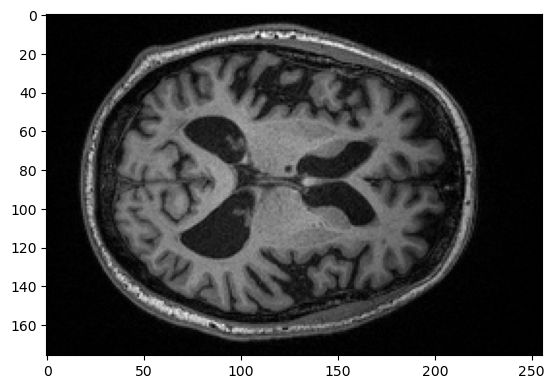

(176, 256)


In [4]:
# Loading .nii file for central slice subject OAS30016
img = nib.load('T1wslices/OAS30016_MR_d0021_77_T1w_NIFTI.nii')
data = img.get_fdata()

# Show image
plt.imshow(data, cmap='gray')
plt.show()
print(data.shape)

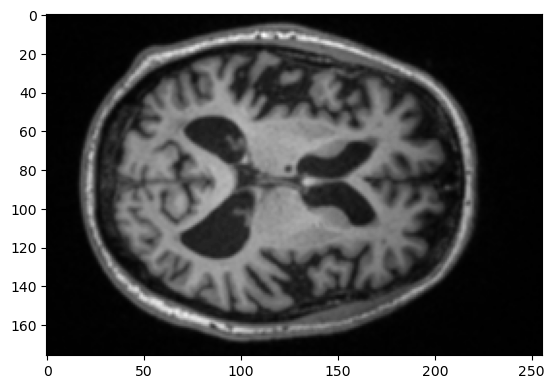

(176, 256)


In [5]:
# Loading .nii file for central slice subject OAS30016 (after preprocessing)
img = nib.load('T1wslicesdementia2/OAS30016_MR_d0021_77_T1w_NIFTI.nii')
data = img.get_fdata()

# Show image
plt.imshow(data, cmap='gray')
plt.show()
print(data.shape)

# 3. CONVOLUTIONAL NEURAL NETWORK (CNN)

### 3.1: Data preparation

In [ ]:
# Path of the folders for the images (saving everything in a new CNN folder for better organization)
os.makedirs('CNN', exist_ok=True)

os.makedirs('CNN/DEM', exist_ok=True)
os.makedirs('CNN/NOTDEM', exist_ok=True)

# Copying the elements that we are going to need (from NOTDEM we are keep only 1000 elements to have more balanced data)
origen1 = "T1wslicesdementia2"
copia1 = "CNN/DEM"
copy_tree(origen1, copia1)

origenlist = os.listdir("T1wslicesnotdementia2")
origen_aleat = random.sample(origenlist, 1000)
origen2 = "T1wslicesnotdementia2"
copia2 = 'CNN/NOTDEM'

for archivo in origen_aleat:
    ruta_origen2 = os.path.join(origen2, archivo)
    ruta_copia2 = os.path.join(copia2, archivo)
    
    # Copy file from origin to destination directory
    shutil.copy(ruta_origen2, ruta_copia2)

In [2]:
dem = 'CNN/DEM'
notdem = 'CNN/NOTDEM'

# Function to load the .nii files and get the image data in NumPy format

def cargaimg(path):
    imgdata = []
    files = os.listdir(path)
    for file in files:
        filepath = os.path.join(path,file)
        img = nib.load(filepath)
        data = img.get_fdata()
        imgdata.append(data)
    return np.array(imgdata)

# Using it to obtain NumPy format of all images
demencia = cargaimg(dem)
nodemencia = cargaimg(notdem)

In [3]:
print('Alzheimer:',len(demencia))
print('To get to 2000 img: 2000 -',len(demencia),'=', 2000-len(demencia))
print('----------------------------------------')
print('Cognitively normal:',len(nodemencia))
print('To get to 2000 img: 2000 -',len(nodemencia),'=', 2000-len(nodemencia))

Alzheimer: 890
To get to 2000 img: 2000 - 890 = 1110
----------------------------------------
Cognitively normal: 1000
To get to 2000 img: 2000 - 1000 = 1000


In [4]:
# Data augmentation:
# Not possible to use ImageDataGenerator because that only supports specific format files (.jpeg, .png...),
# so applying data augmentation to variables in NumPy format

# Function for data augmentation of images with 20º max. rotations
def aplicar_aumentos(imagenes, cantidadimg):
    imagenesplus = []
    while len(imagenesplus) < cantidadimg:
        # Selecting random image from the list
        idx = np.random.randint(0, len(imagenes))
        imagen = imagenes[idx]

        # Applying random transformations inside the stablished range
        angulo_rotacion = np.random.uniform(-20, 20)
        imagen_rotada = transform.rotate(imagen, angle=angulo_rotacion, mode='constant', cval=0)

        # Saving in new list
        imagenesplus.append(imagen_rotada)

    return np.array(imagenesplus)

# Using amplifying function in both directories
demenciaplus = aplicar_aumentos(demencia, 1110)
nodemenciaplus = aplicar_aumentos(nodemencia, 1000)

### 3.2: Data division (train, test, validation)

In [5]:
# Creating labels
etiquetadem = np.ones(len(demencia)+len(demenciaplus))
etiquetanodem = np.zeros(len(nodemencia)+len(nodemenciaplus))

imagenes = np.concatenate([demencia,demenciaplus,nodemencia,nodemenciaplus]) # All images
etiquetas = np.concatenate([etiquetadem,etiquetanodem]) # All labels
# Concatenate to obtain vectors (X and Y or input and output)

# Dividing train 70%, validation 15% and test 15%
Xtrain, Xtest, Ytrain, Ytest = train_test_split(imagenes, etiquetas, test_size=0.3, random_state=42)

Xval, Xtest, Yval, Ytest = train_test_split(Xtest, Ytest, test_size=0.5, random_state=42)

### 3.3: CNN model construction

In [ ]:
# Defining CNN
modelito = models.Sequential()

# Convolutional layer 1
modelito.add(Conv2D(32, (3, 3), activation='relu', input_shape=(176, 256, 1))) # 1 chanel because of gray scale (MRI)
# Max Pooling (Pooling layers that reduce the size of the output of convolutional layers)
modelito.add(MaxPooling2D(pool_size=(3, 3), padding='valid')) 

# Convolutional layer 2
modelito.add(Conv2D(64, (5, 5), activation='relu'))
# Max Pooling
modelito.add(MaxPooling2D(pool_size=(5, 5), padding='valid'))

# Convolutional layer 3
modelito.add(Conv2D(128, (3, 3), activation='relu'))
# Max Pooling
modelito.add(MaxPooling2D(pool_size=(5, 5), strides=(2,2)))


# Transforming data to flattened vector (to flatten data un unidimensional vector before the dense layers)
modelito.add(Flatten()) 

# Completely connected layer that performs classification
modelito.add(Dense(512, activation='relu')) 
# 512 neurons is a common choice because it balances representational capacity with computational efficiency

modelito.add(Dropout(0.5)) # Regularization layer that helps prevent overfitting by randomly removing some neural connections during training

# Output layer with sigmoid activation (because it is binary qualified)
modelito.add(Dense(1, activation='sigmoid')) 



modelito.compile(optimizer='adam', # adam is a commonly used optimizer
                 loss='binary_crossentropy', # Because we want binary output
                 metrics=['accuracy'])

### 3.4: Model training

In [ ]:
# Model training
history = modelito.fit(Xtrain, Ytrain, epochs=11, batch_size=64,  
                    validation_data=(Xval, Yval))

# Evaluating model with test
test_loss, test_acc = modelito.evaluate(Xtest, Ytest)
print(f'Accuracy on test set: {test_acc}')

# Saving model
modelito.save('modeloT1wdataplus355-11ep.h5')

### 3.5: Model evaluation

In [ ]:
# Obtaining info of loss and accuracy from record
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Loss graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy graph
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### 3.6: Model adjustion and other trials: Pretrained network (VGG16)

In [8]:
# Creating labels
etiquetadem = np.ones(len(demencia)+len(demenciaplus))
etiquetanodem = np.zeros(len(nodemencia)+len(nodemenciaplus))

imagenes = np.concatenate([demencia,demenciaplus,nodemencia,nodemenciaplus]) # All images
etiquetas = np.concatenate([etiquetadem,etiquetanodem]) # All labels
# Concatenate to obtain vectors (X and Y or input and output)

# Replicate the grayscale channel to have three identical channels (needed for the pretrained network)
imagenesrgb = np.repeat(imagenes[..., np.newaxis], 3, -1)

# Dividing train 70%, validation 15% and test 15%
Xtrain, Xtest, Ytrain, Ytest = train_test_split(imagenesrgb, etiquetas, test_size=0.3, random_state=42)

Xval, Xtest, Yval, Ytest = train_test_split(Xtest, Ytest, test_size=0.5, random_state=42)

In [11]:
# Pretrained network

# Download the VGG16 pretrained model without the dense layers (including the convolutional part)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(176, 256, 3))

# Add custom dense layers to fit the model to data set
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)  #Output layer for bonary classification

# Create the new model using the VGG16 pre-trained base and custom layers
modelitopre = Model(inputs=base_model.input, outputs=x)

# Compile
modelitopre.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# Model training
history = modelitopre.fit(Xtrain, Ytrain, epochs=11, batch_size=64,  
                    validation_data=(Xval, Yval))

# Evaluating model with test
test_loss, test_acc = modelitopre.evaluate(Xtest, Ytest)
print(f'Accuracy on test set: {test_acc}')

# Saving model
modelitopre.save('modelopreT1wdataplus355f.h5')

Epoch 1/11
44/44 [==============================] - 1044s 24s/step - loss: 0.7393 - accuracy: 0.5082 - val_loss: 0.6894 - val_accuracy: 0.5267
Epoch 2/11
44/44 [==============================] - 1034s 24s/step - loss: 0.6880 - accuracy: 0.5475 - val_loss: 0.6784 - val_accuracy: 0.5700
Epoch 3/11
44/44 [==============================] - 1035s 24s/step - loss: 0.6757 - accuracy: 0.5754 - val_loss: 0.6588 - val_accuracy: 0.6317
Epoch 4/11
44/44 [==============================] - 1033s 23s/step - loss: 0.6385 - accuracy: 0.6411 - val_loss: 0.6012 - val_accuracy: 0.6750
Epoch 5/11
44/44 [==============================] - 1062s 24s/step - loss: 0.5962 - accuracy: 0.6875 - val_loss: 0.5834 - val_accuracy: 0.7000
Epoch 6/11
44/44 [==============================] - 1196s 27s/step - loss: 0.5826 - accuracy: 0.7011 - val_loss: 0.6125 - val_accuracy: 0.6617
Epoch 7/11
44/44 [==============================] - 1179s 27s/step - loss: 0.5298 - accuracy: 0.7296 - val_loss: 0.5178 - val_accuracy: 0.7583

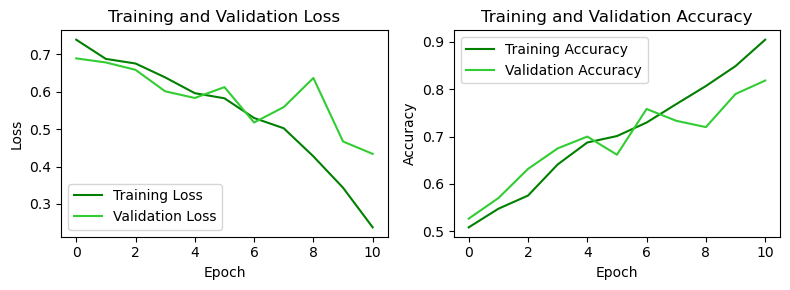

In [22]:
# Get loss and accuracy information from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Create loss plots
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='green')
plt.plot(val_loss, label='Validation Loss', color='limegreen')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Create accuracy plots
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy', color='green')
plt.plot(val_acc, label='Validation Accuracy', color='limegreen')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 4. PREDICCIONES

If extracted from the model obtained above:

In [ ]:
# Get predictions from the model on the test set
predictions = modelitopre.predict(Xtest)
predictedlabels = (predictions > 0.5).astype("int32")  # Convert probabilities to binary labels (0 or 1)

# Show some images from the test set along with their predictions and real labels
numimg = 10  # Number of images to display

plt.figure(figsize=(15, 3 * numimg))
for i in range(numimg):
    # Show the image
    plt.subplot(numimg, 2, 2 * i + 1)
    plt.imshow(Xtest[i], cmap='gray')
    plt.title(f"Prediction: {predictedlabels[i][0]}, Real Label: {Ytest[i]}")
    plt.axis('off')

    # Show the bar chart of predicted probabilities
    plt.subplot(numimg, 2, 2 * i + 2)
    plt.bar(np.arange(2), [1 - predictions[i], predictions[i]], tick_label=['Cognitively normal', 'Alzheimer'])
    plt.ylabel('Probability')
    plt.ylim([0, 1])

plt.tight_layout()
plt.show()

If extracted from models previously saved:

In [13]:
# Load model from .h5 file
loadedmodel = load_model('modelopreT1wdataplus355.h5') # Best model obtained in this case

In [ ]:
# Get predictions from the model on the test set
predictions = loadedmodel.predict(Xtest)
predictedlabels = (predictions > 0.5).astype("int32")  # Convert probabilities to binary labels (0 or 1)

# Show some images from the test set along with their predictions and real labels
numimg = 10  # Number of images to display

plt.figure(figsize=(15, 3 * numimg))
for i in range(numimg):
    # Show the image
    plt.subplot(numimg, 2, 2 * i + 1)
    plt.imshow(Xtest[i], cmap='gray')
    plt.title(f"Prediction: {predictedlabels[i][0]}, Real Label: {Ytest[i]}")
    plt.axis('off')

    # Show the bar chart of predicted probabilities
    plt.subplot(numimg, 2, 2 * i + 2)
    plt.bar(np.arange(2), [float(1 - predictions[i]), float(predictions[i])], tick_label=['Cognitively normal', 'Alzheimer'], color='#b7e6a5')
    plt.ylabel('Probability')
    plt.ylim([0, 1])

plt.tight_layout()
plt.show()

19/19 [==============================] - 99s 5s/step
Confusion Matrix:
[[219  58]
 [ 39 284]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.79      0.82       277
         1.0       0.83      0.88      0.85       323

    accuracy                           0.84       600
   macro avg       0.84      0.83      0.84       600
weighted avg       0.84      0.84      0.84       600



<Figure size 1200x400 with 0 Axes>

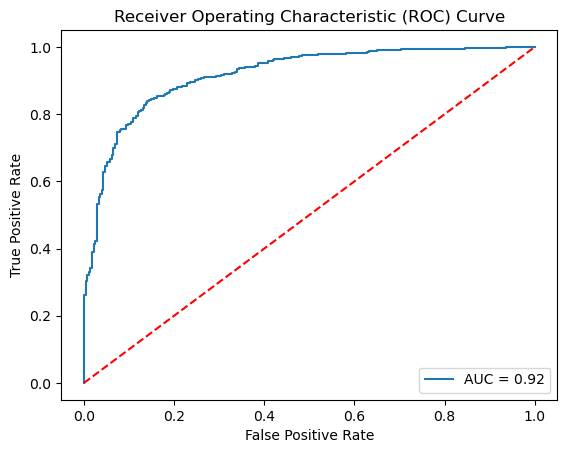

In [14]:
# Load .h5 model
model = load_model('modelopreT1wdataplus355.h5')

# Predictions on test
predictions = model.predict(Xtest)
predicted_labels = (predictions > 0.5).astype("int32")  # 0.5 can be modified as threshold to act on recall




# Obtain metrics and graphs:
plt.figure(figsize=(12, 4))

# Confusion matrix
conf_matrix = confusion_matrix(Ytest, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(Ytest, predicted_labels)
print("Classification Report:")
print(class_report)

# ROC AUC
fpr, tpr, thresholds = roc_curve(Ytest, predictions)
roc_auc = roc_auc_score(Ytest, predictions)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()